# Imports and Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('filtered.pkl', 'rb') as handle:
    filtered = pickle.load(handle)
handle.close()

with open('filterednc.pkl', 'rb') as handle:
    filterednc = pickle.load(handle)
handle.close()

globalt0 = dt.datetime.now()

In [2]:
import statsmodels.api as sm

# Explore CV of interevent times

The idea is to pick a few alters that receive a high number of phone calls and check if the distribution for their intervent times show a particular distribution. The main goal is to use those distributions as a way to give a certainty that a relationship observed at the beginning of the data is actually a **new** relationship and not just a continuing one being observed due to the beginning of data. Same goes for the (observed) end of a relationship.

However, before doing this I need to get the pairs of ego alter and sort them by activity (total number of phone calls). As the first try, I'll use the filtered data including the cores

In [3]:
filt_pairs = {}
for c in filtered.keys():
    filt_pairs[c] = pc.pairs(filtered[c])
    filt_pairs[c].sort_values(by='nij', ascending=False, inplace=True)
    filt_pairs[c] = filt_pairs[c].loc[filt_pairs[c]['nij'] >= 3]

In [4]:
filt_pairs['uk']

ego         alter   nij    k     n
554   C07817280467  C07816637861  1413  134  3873
150   C07800643466  C07800643415  1203  188  4429
2664  C07800643415  C07800643466  1062   90  1990
949   C07814508939  C07950483877   813  136  3261
579   C07817280467  C07973283191   727  134  3873
...            ...           ...   ...  ...   ...
3579  C07800755987   C7814339501     3   91  1151
4620  C07890948782  C07757980532     3   55   297
36    C07800643466  C07849638750     3  188  4429
3372  C07970136770  C01142622640     3  177  1304
4488  C07800650511  C07971512020     3   76   643

[1944 rows x 5 columns]

In [5]:
egos = [filt_pairs['uk2'].at[i, 'ego'] for i in list(filt_pairs['uk2'].index)[:100]]
alters = [filt_pairs['uk2'].at[i, 'alter'] for i in list(filt_pairs['uk2'].index)[:100]]

In [6]:
df = filtered['uk'].loc[(filtered['uk']['ego'] == egos[0]) & (filtered['uk']['alter'] == alters[0])]
df

ego         alter                time  uclock  aclock   rm
1533  C07814508939  C07950483877 2007-12-02 21:05:00     272       0  0.0
1534  C07814508939  C07950483877 2007-12-04 09:28:00     273       1  0.0
1535  C07814508939  C07950483877 2007-12-04 14:16:00     274       2  0.0
1536  C07814508939  C07950483877 2007-12-04 18:14:00     274       2  0.0
1537  C07814508939  C07950483877 2007-12-04 18:22:00     274       2  0.0
...            ...           ...                 ...     ...     ...  ...
2341  C07814508939  C07950483877 2008-06-19 13:19:00     472     200  0.0
2342  C07814508939  C07950483877 2008-06-19 22:05:00     472     200  0.0
2343  C07814508939  C07950483877 2008-06-19 22:11:00     472     200  0.0
2344  C07814508939  C07950483877 2008-06-19 23:10:00     472     200  0.0
2345  C07814508939  C07950483877 2008-06-20 00:15:00     472     200  0.0

[813 rows x 6 columns]

In [7]:
df['ie'] = df['aclock'].diff()
df

<ipython-input-7-7bb031b5eaac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ie'] = df['aclock'].diff()


ego         alter                time  uclock  aclock   rm   ie
1533  C07814508939  C07950483877 2007-12-02 21:05:00     272       0  0.0  NaN
1534  C07814508939  C07950483877 2007-12-04 09:28:00     273       1  0.0  1.0
1535  C07814508939  C07950483877 2007-12-04 14:16:00     274       2  0.0  1.0
1536  C07814508939  C07950483877 2007-12-04 18:14:00     274       2  0.0  0.0
1537  C07814508939  C07950483877 2007-12-04 18:22:00     274       2  0.0  0.0
...            ...           ...                 ...     ...     ...  ...  ...
2341  C07814508939  C07950483877 2008-06-19 13:19:00     472     200  0.0  1.0
2342  C07814508939  C07950483877 2008-06-19 22:05:00     472     200  0.0  0.0
2343  C07814508939  C07950483877 2008-06-19 22:11:00     472     200  0.0  0.0
2344  C07814508939  C07950483877 2008-06-19 23:10:00     472     200  0.0  0.0
2345  C07814508939  C07950483877 2008-06-20 00:15:00     472     200  0.0  0.0

[813 rows x 7 columns]

0.24630541871921183 0.5045835675783991


(array([634.,   0., 161.,   0.,   0.,  13.,   0.,   3.,   0.,   1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

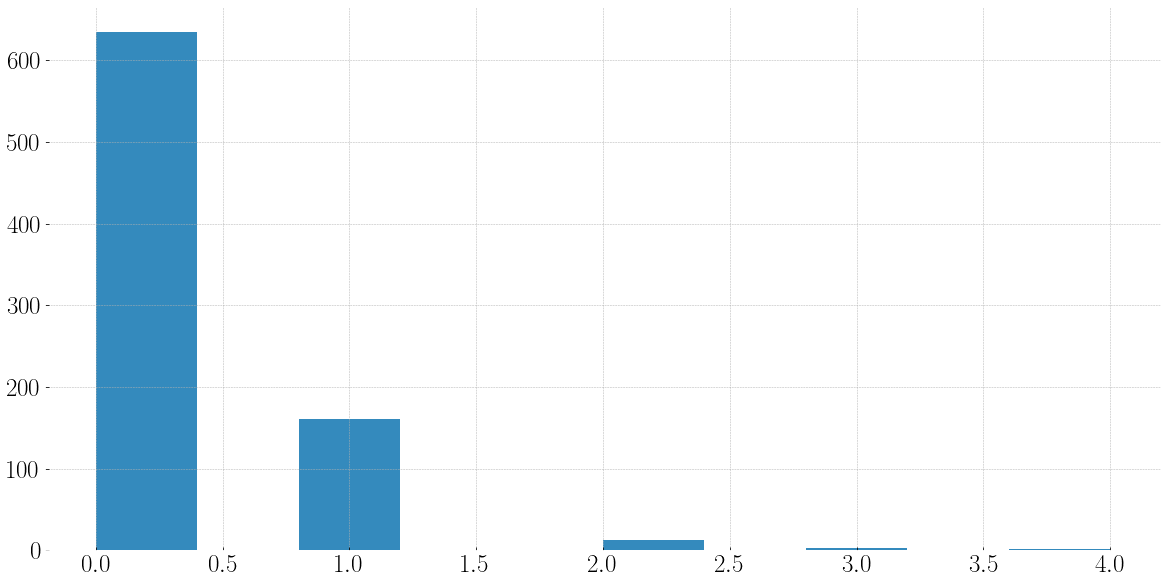

In [8]:
print(np.mean(list(df['ie'])[1:]), np.std(list(df['ie'])[1:]))
plt.hist(df['ie'])

0.27548209366391185 0.7668255745608484


<ipython-input-9-e570bed42024>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ie'] = df['aclock'].diff()


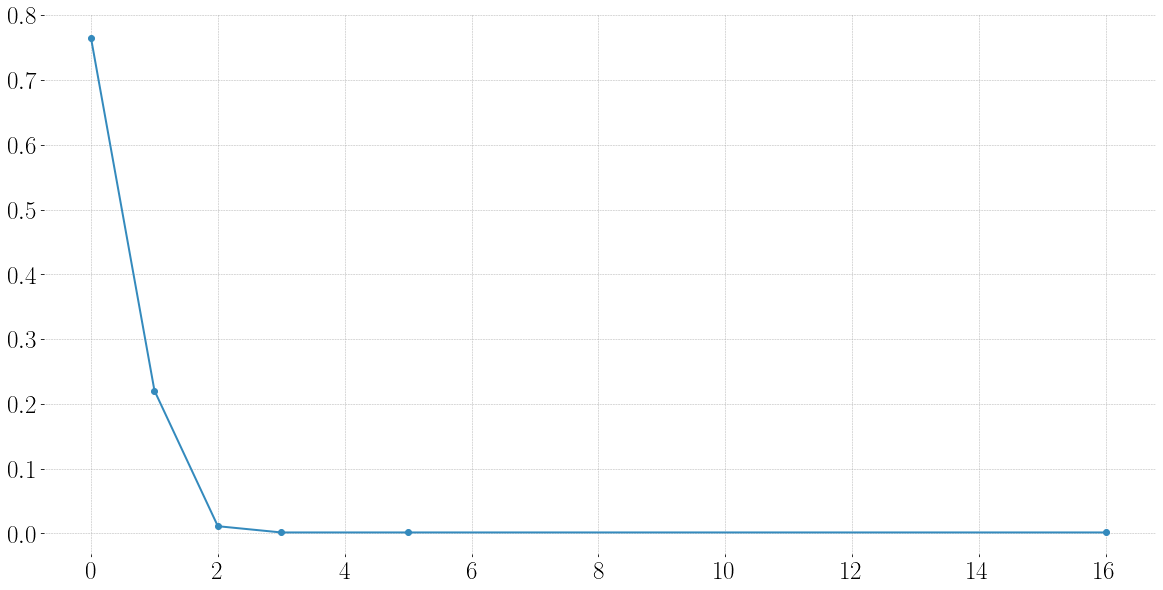

In [9]:
df = filtered['uk2'].loc[(filtered['uk2']['ego'] == egos[1]) & (filtered['uk2']['alter'] == alters[1])]
df['ie'] = df['aclock'].diff()
H = {}
for i in list(df['ie'])[1:]:
    H[i] = H.get(i, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index').sort_index()
print(np.mean(list(df['ie'])[1:]), np.std(list(df['ie'])[1:]))
plt.plot(H.index, H[0] / sum(H[0]), "o-")

3.7358490566037736 11.04391054509948


<ipython-input-10-f25eb563ef48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ie'] = df['aclock'].diff()


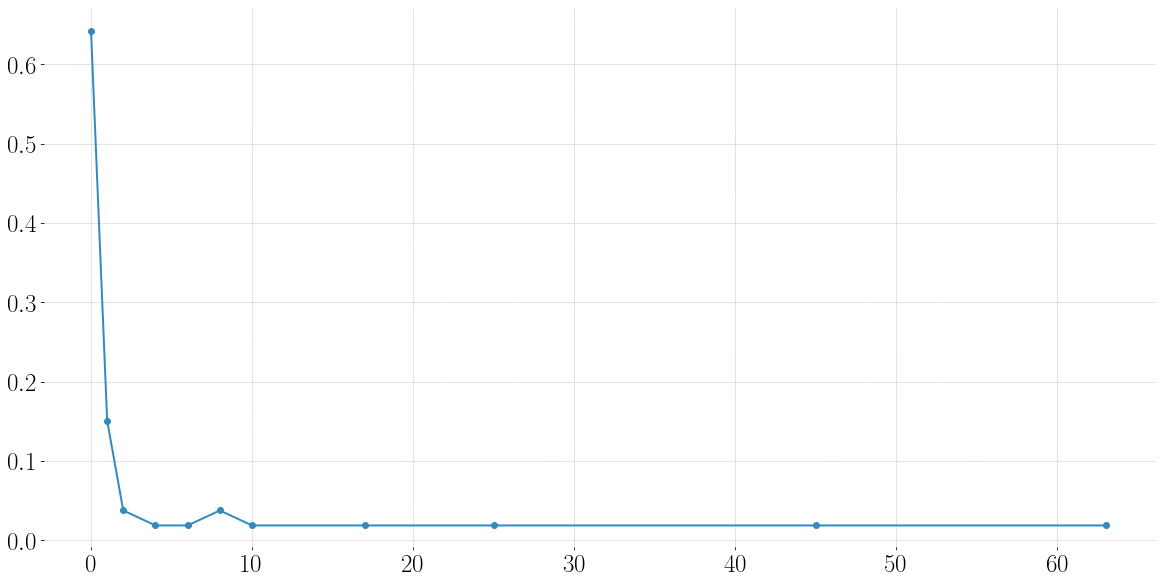

In [10]:
df = filtered['uk2'].loc[(filtered['uk2']['ego'] == egos[70]) & (filtered['uk2']['alter'] == alters[70])]
df['ie'] = df['aclock'].diff()
H = {}
for i in list(df['ie'])[1:]:
    H[i] = H.get(i, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index').sort_index()
print(np.mean(list(df['ie'])[1:]), np.std(list(df['ie'])[1:]))
plt.plot(H.index, H[0] / sum(H[0]), "o-")

In [11]:
t0 = dt.datetime.now()
for c in filt_pairs.keys():
    df = filt_pairs[c]
    for i in df.index:
        ego = df.at[i, 'ego']
        alter = df.at[i, 'alter']
        df1 = filtered[c].loc[(filtered[c]['ego'] == ego) & (filtered[c]['alter'] == alter)]
        df1['ie'] = df1['aclock'].diff()
        ie_mean = np.mean(list(df1['ie'])[1:])
        ie_std = np.std(list(df1['ie'])[1:])
        filt_pairs[c].at[i, 'ie_mean'] = ie_mean
        filt_pairs[c].at[i, 'ie_std'] = ie_std
print(f'This block took {dt.datetime.now() - t0}')

<ipython-input-11-5dd38893406d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ie'] = df1['aclock'].diff()


This block took 4:01:39.988606


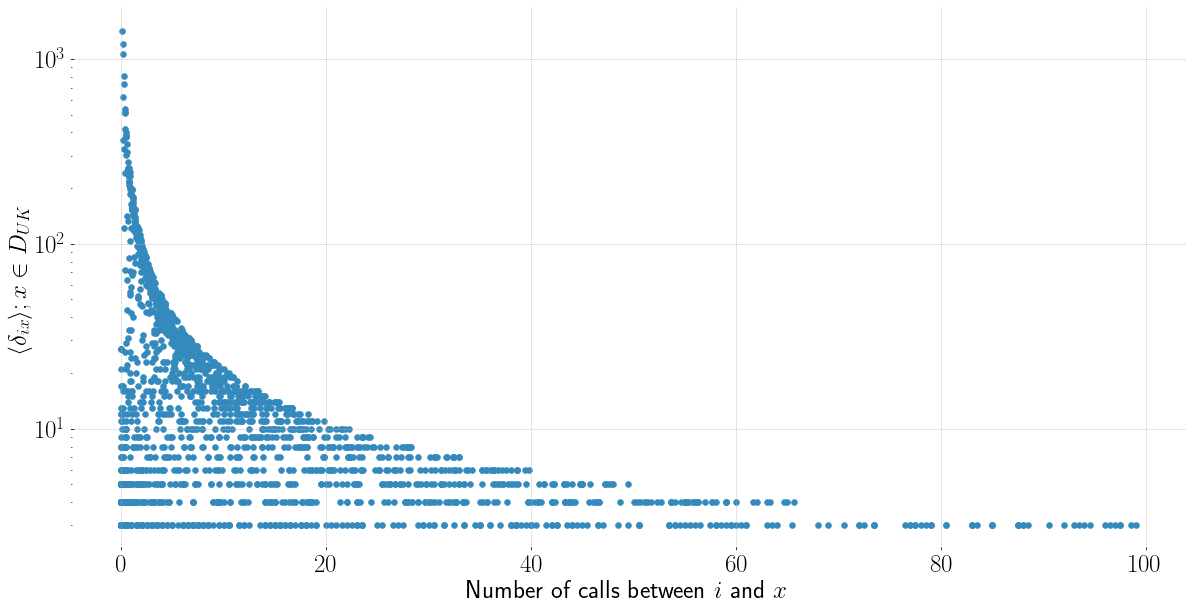

In [12]:
plt.ylabel(r'$\langle \delta_{ix} \rangle; x \in D_{UK}$')
plt.xlabel(r'Number of calls between $i$ and $x$')
plt.semilogy()
plt.scatter(filt_pairs['uk']['ie_mean'], filt_pairs['uk']['nij'])

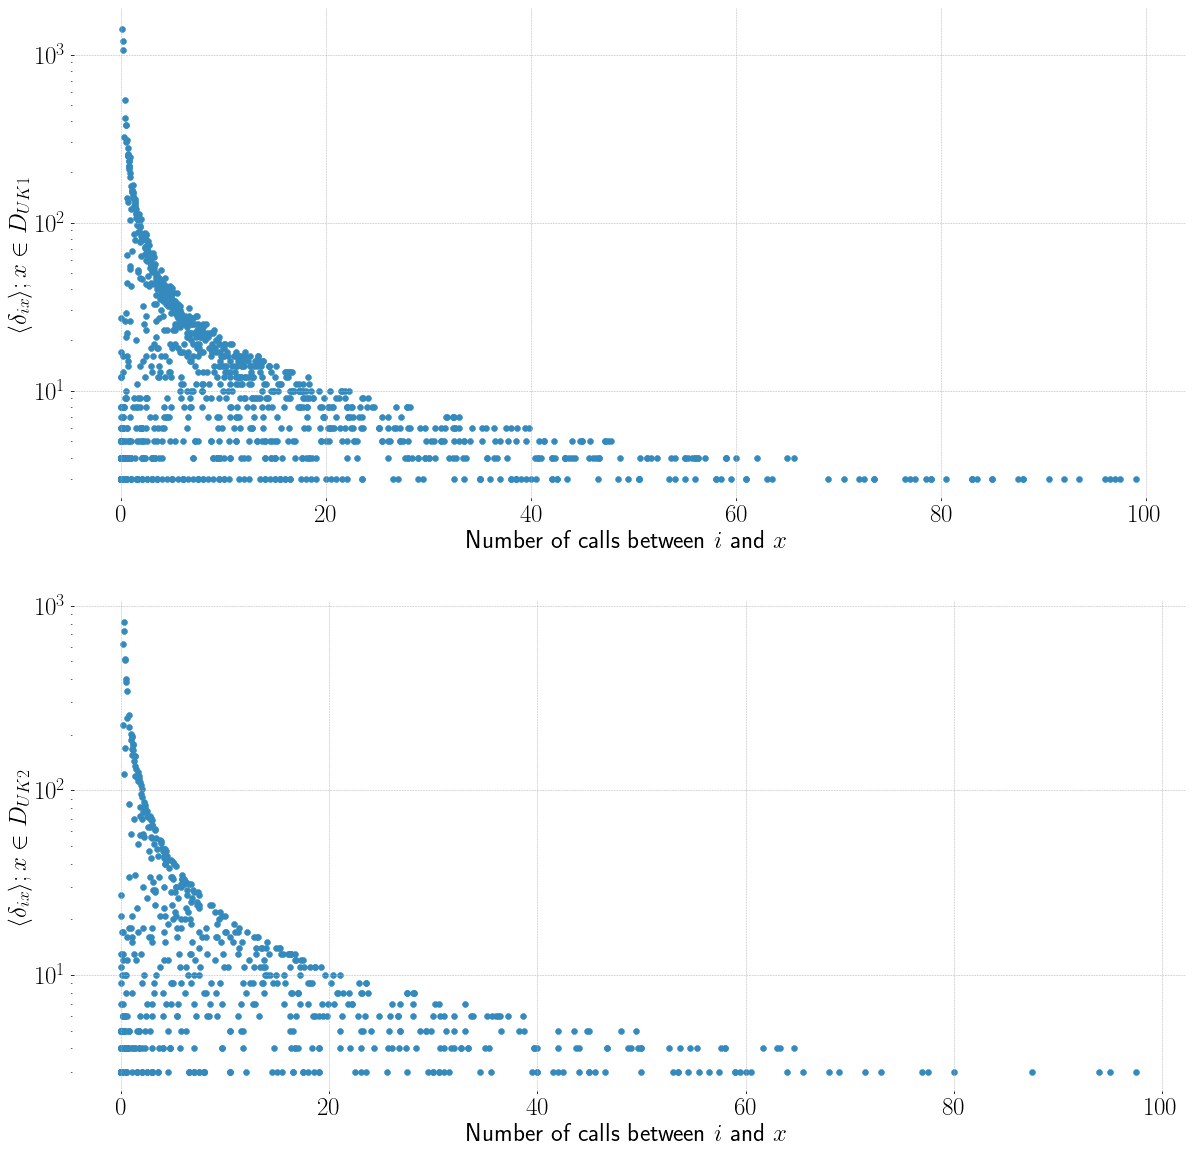

In [13]:
plt.figure(figsize=(20, 20))

plt.subplot(211)
plt.ylabel(r'$\langle \delta_{ix} \rangle; x \in D_{UK1}$')
plt.xlabel(r'Number of calls between $i$ and $x$')
plt.semilogy()
plt.scatter(filt_pairs['uk1']['ie_mean'], filt_pairs['uk1']['nij'])

plt.subplot(212)
plt.ylabel(r'$\langle \delta_{ix} \rangle; x \in D_{UK2}$')
plt.xlabel(r'Number of calls between $i$ and $x$')
plt.semilogy()
plt.scatter(filt_pairs['uk2']['ie_mean'], filt_pairs['uk2']['nij'])

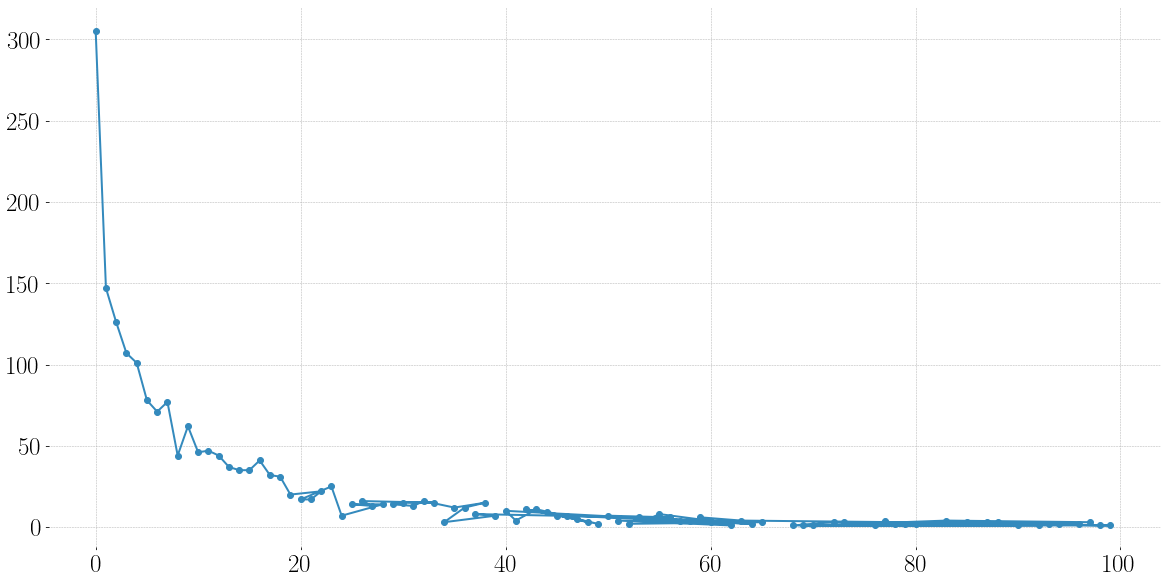

In [14]:
H = {}
for i in filt_pairs['uk']['ie_mean']:
    x = int(i)
    H[x] = H.get(x, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index')
plt.plot(H.index, H[0], "o-")

(array([101., 120., 159., 204., 229., 243., 213., 182., 133.,  55.]),
 array([0.        , 0.45951199, 0.91902397, 1.37853596, 1.83804794,
        2.29755993, 2.75707191, 3.2165839 , 3.67609588, 4.13560787,
        4.59511985]),
 <BarContainer object of 10 artists>)

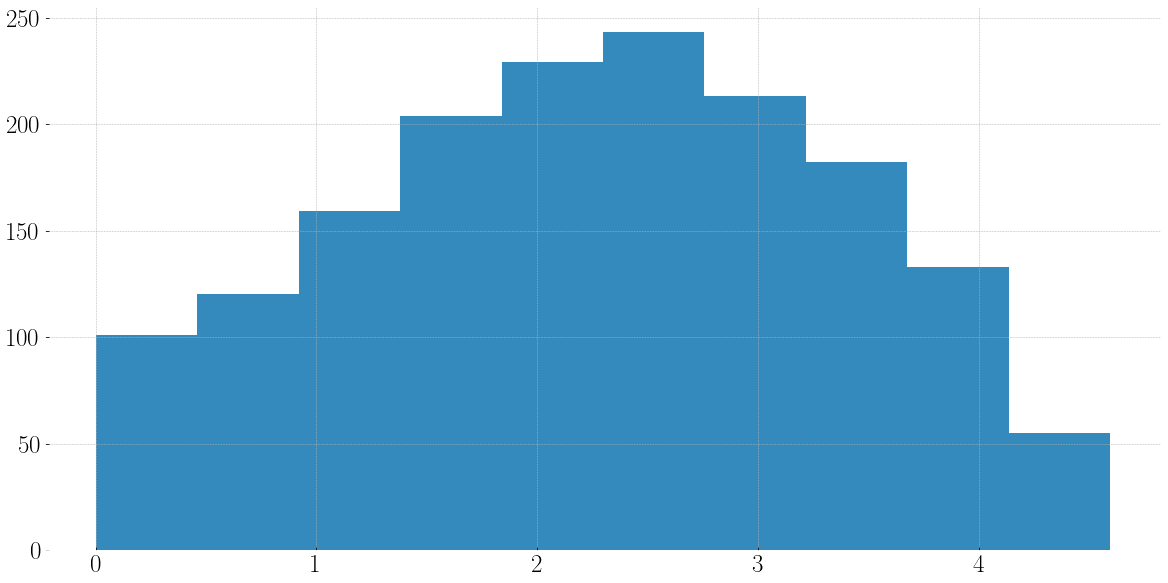

In [15]:
df = filt_pairs['uk'].loc[filt_pairs['uk']['ie_mean'] >= 1]
Y = np.log(df['ie_mean'])
plt.hist(Y)

## Asuming log-normal distribution

In [16]:
filt_pairs['uk'].head()

ego         alter   nij    k     n   ie_mean    ie_std
554   C07817280467  C07816637861  1413  134  3873  0.122521  0.674192
150   C07800643466  C07800643415  1203  188  4429  0.133111  0.996960
2664  C07800643415  C07800643466  1062   90  1990  0.160226  0.678720
949   C07814508939  C07950483877   813  136  3261  0.246305  0.504584
579   C07817280467  C07973283191   727  134  3873  0.275482  0.765027

Looking at the pair of ego alter in the first row

In [17]:
df = filtered['uk'].loc[(filtered['uk']['ego'] == 'C07817280467') & (filtered['uk']['alter'] == 'C07816637861')]

In [18]:
df.head()

ego         alter                time  uclock  aclock   rm
44316  C07817280467  C07816637861 2007-04-04 19:31:00      30       0  1.0
44317  C07817280467  C07816637861 2007-04-17 14:17:00      43      13  1.0
44318  C07817280467  C07816637861 2007-04-17 14:17:00      43      13  1.0
44319  C07817280467  C07816637861 2007-04-17 16:58:00      43      13  1.0
44320  C07817280467  C07816637861 2007-04-17 17:13:00      43      13  1.0

In [19]:
for c in filt_pairs.keys():
    df = filt_pairs[c]
    for i in df.index:
        df.at[i, 'p-new'] = stats.lognorm.sf(7, s=df.at[i, 'ie_std'], loc = df.at[i, 'ie_mean'])

In [20]:
for c in filt_pairs.keys():
    df = filt_pairs[c]
    new = 0
    for i in df.index:
        if df.at[i, 'p-new'] < 0.1:
            new += 1
    print(f'{c}: {new} new relationships detected, of a total of {len(df)}. Using 10%')

mit: 313 new relationships detected, of a total of 3047. Using 10%
uk1: 76 new relationships detected, of a total of 1163. Using 10%
uk2: 62 new relationships detected, of a total of 690. Using 10%
uk: 146 new relationships detected, of a total of 1944. Using 10%
all: 565 new relationships detected, of a total of 5747. Using 10%


# Identify *communication seasons*

In [21]:
filt_pairs['uk'].tail(1000)

ego         alter  nij    k     n    ie_mean     ie_std  \
3130  C07974937643  C01142668510    8  170  1368  10.714286  18.606560   
2282  C07792057901  C01142662662    8  154  2210  17.428571  18.607657   
2109  C07999103487  C07825647691    8  495  2589  17.000000  27.650885   
557   C07817280467  C07806784520    8  134  3873  27.571429  64.692365   
3325  C07970136770  C07889859019    8  177  1304   6.142857   9.731078   
...            ...           ...  ...  ...   ...        ...        ...   
3579  C07800755987   C7814339501    3   91  1151  14.500000  14.500000   
4620  C07890948782  C07757980532    3   55   297  38.000000  38.000000   
36    C07800643466  C07849638750    3  188  4429   2.500000   1.500000   
3372  C07970136770  C01142622640    3  177  1304  96.000000  81.000000   
4488  C07800650511  C07971512020    3   76   643   0.000000   0.000000   

         p-new  
3130  1.000000  
2282  1.000000  
2109  1.000000  
557   1.000000  
3325  0.506319  
...        ...  
3579  1.000000  
4620  1.000000  
36    0.157998  
3372  1.000000  
4488       NaN  

[1000 rows x 8 columns]

In [22]:
df = filtered['uk']
df1 = df.loc[(df['ego'] == 'C07817280467') & (df['alter'] == 'C07816637861')]

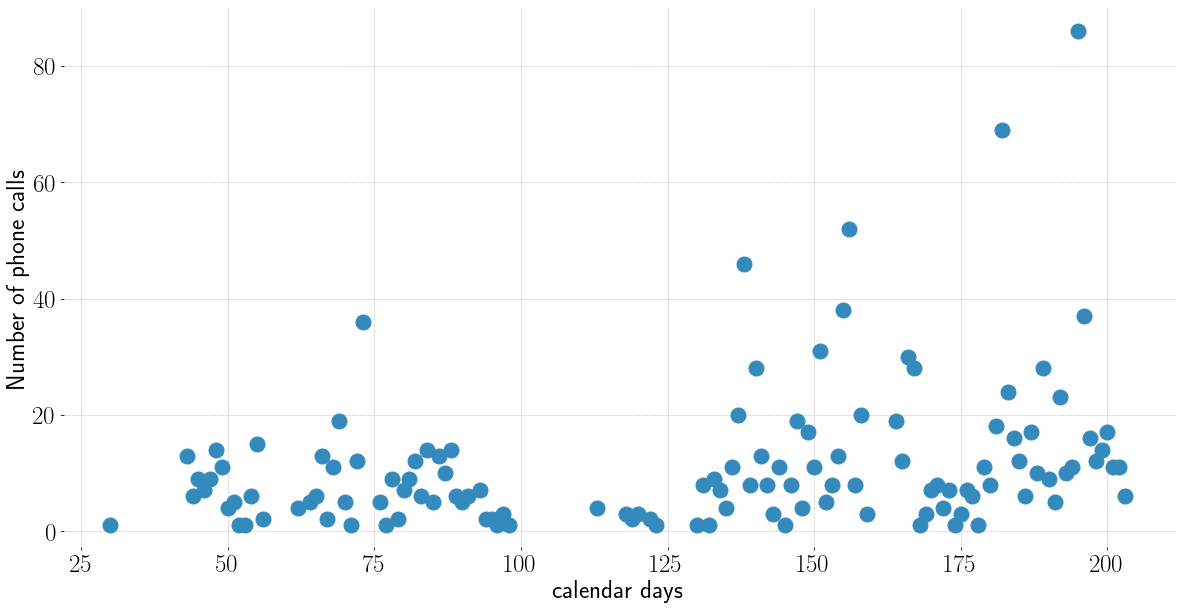

In [23]:
H = {}
for d in df1['uclock']:
    df2 = df1.loc[df1['uclock'] == d]
    H[d] = len(df2)
H = pd.DataFrame.from_dict(H, orient='index')

plt.xlabel("calendar days")
plt.ylabel("Number of phone calls")
plt.plot(H.index, H[0], "o", markersize=15)

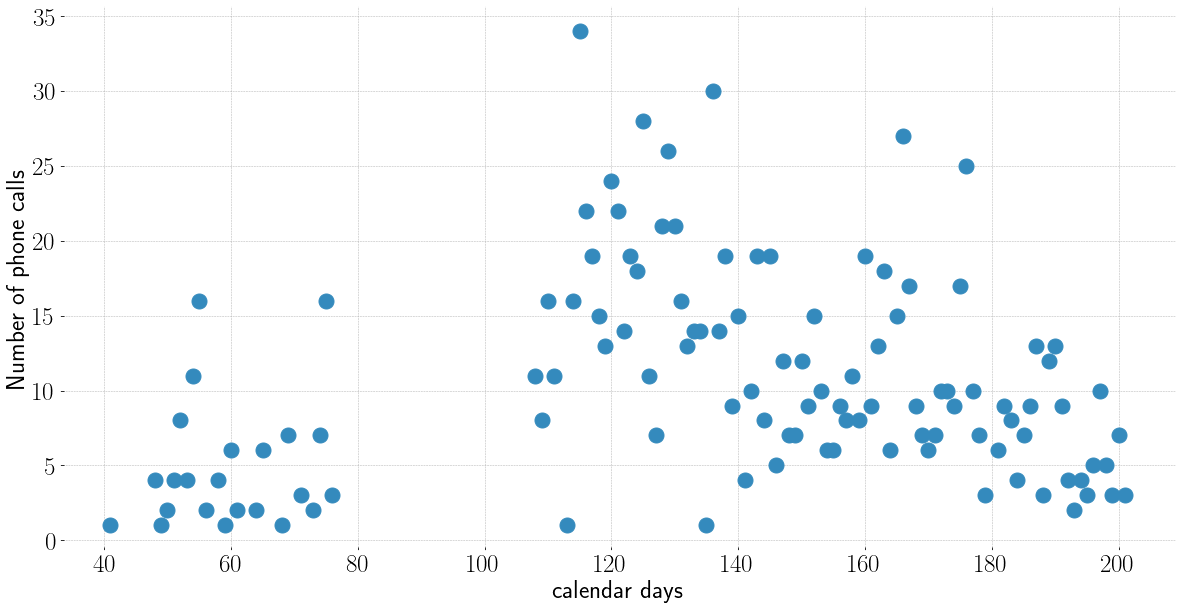

In [24]:
df1 = df.loc[(df['ego'] == 'C07800643466') & (df['alter'] == 'C07800643415')]
H = {}
for d in df1['uclock']:
    df2 = df1.loc[df1['uclock'] == d]
    H[d] = len(df2)
H = pd.DataFrame.from_dict(H, orient='index')

plt.xlabel("calendar days")
plt.ylabel("Number of phone calls")
plt.plot(H.index, H[0], "o", markersize=15)

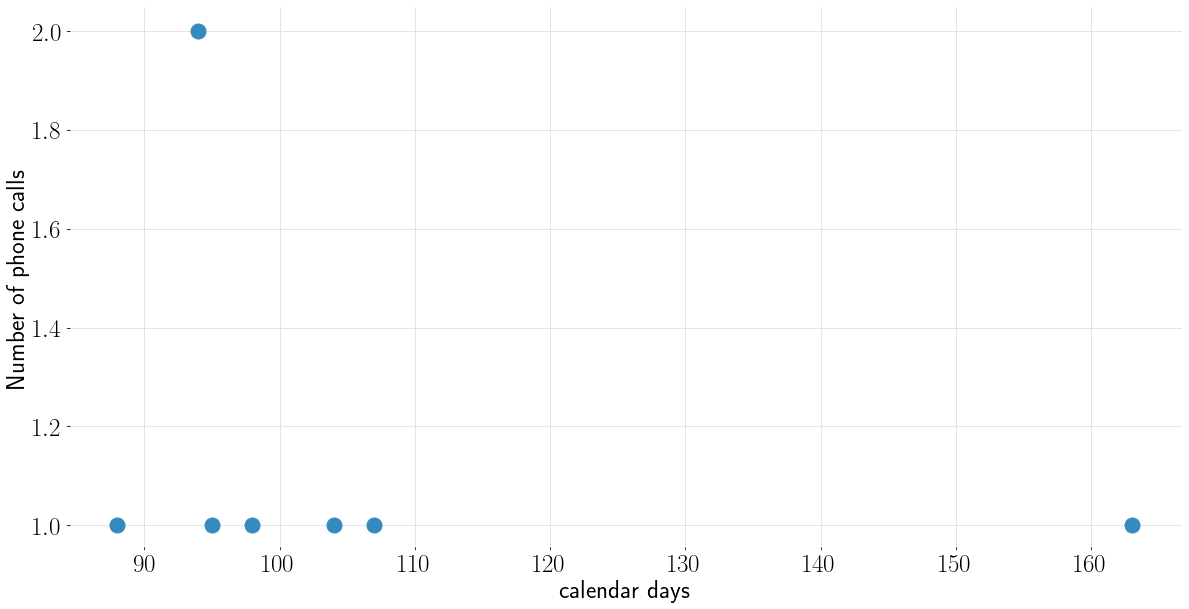

In [25]:
df1 = df.loc[(df['ego'] == 'C07974937643') & (df['alter'] == 'C01142668510')]
H = {}
for d in df1['uclock']:
    df2 = df1.loc[df1['uclock'] == d]
    H[d] = len(df2)
H = pd.DataFrame.from_dict(H, orient='index')

plt.xlabel("calendar days")
plt.ylabel("Number of phone calls")
plt.plot(H.index, H[0], "o", markersize=15)

In [26]:
t0 = dt.datetime.now()
seasons = {}
for c in filt_pairs.keys():
    df = filt_pairs[c]
    dfres = pd.DataFrame()
    idx = 0
    for i in df.index:
        ego = df.at[i, 'ego']
        alter = df.at[i, 'alter']
        df1 = filtered[c].loc[(filtered[c]['ego'] == ego) & (filtered[c]['alter'] == alter)]
        alldays = list(df1['uclock'].unique())
        mint = min(alldays)
        maxt = max(alldays)
        start_season = []
        for d in range(mint + 1, maxt):
            if (d - 1 not in alldays) and (d in alldays) and (d + 1 in alldays):
                start_season.append(d)
        dfres.at[idx, 'ego'] = ego
        dfres.at[idx, 'alter'] = alter
        dfres.at[idx, 'n_seasons'] = len(start_season)
        #dfres.at[idx, 'start_season'] = start_season
        idx += 1
    seasons[c] = dfres
print(f'Took {dt.datetime.now() - t0}')

Took 0:01:48.685050


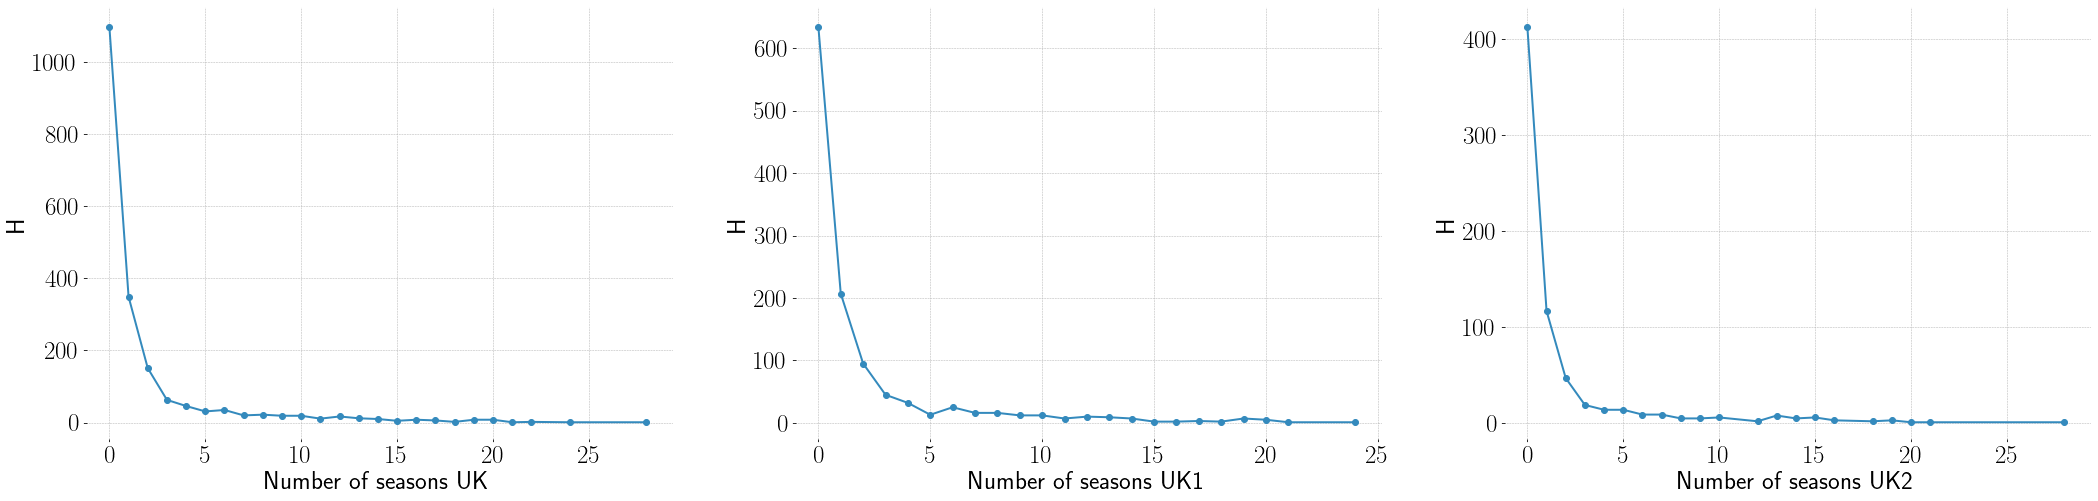

In [27]:
plt.figure(figsize=(36, 8))

plt.subplot(131)
plt.xlabel("Number of seasons UK")
plt.ylabel("H")
H = {}
for s in seasons['uk']['n_seasons']:
    H[s] = H.get(s, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index').sort_index()
plt.plot(H.index, H[0], "o-")

plt.subplot(132)
plt.xlabel("Number of seasons UK1")
plt.ylabel("H")
H = {}
for s in seasons['uk1']['n_seasons']:
    H[s] = H.get(s, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index').sort_index()
plt.plot(H.index, H[0], "o-")

plt.subplot(133)
plt.xlabel("Number of seasons UK2")
plt.ylabel("H")
H = {}
for s in seasons['uk2']['n_seasons']:
    H[s] = H.get(s, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index').sort_index()
plt.plot(H.index, H[0], "o-")

In [28]:
def get_temp_hist(df, ego, alter):
    df1 = df.loc[(df['ego'] == ego) & (df['alter'] == alter)]
    H = {}
    for d in df1['uclock']:
        df2 = df1.loc[df1['uclock'] == d]
        H[d] = len(df2)
    H = pd.DataFrame.from_dict(H, orient='index').sort_index()
    return H

# Max number of days without communication

I'll take this measurement for every ego. I'll get the distribution of the maximum number of days without communication between ego and all of its alters

In [29]:
filt_pairs['uk'].sort_values(by='k', ascending=False, inplace=True)

In [30]:
filt_pairs['uk'].head()

ego         alter  nij    k     n    ie_mean     ie_std  \
1450  C07800759255  C01142253731    8  497  2730  23.714286  17.185661   
1471  C07800759255  C07796835479   14  497  2730   2.153846   6.904248   
1481  C07800759255  C07854475855    5  497  2730  13.250000  13.645054   
1414  C07800759255  C01142074267    5  497  2730  14.750000  22.219080   
1488  C07800759255  C07875703295   15  497  2730  11.714286  24.028045   

         p-new  
1450  1.000000  
1471  0.409597  
1481  1.000000  
1414  1.000000  
1488  1.000000

In [31]:
anego = filt_pairs['uk'].at[1450, 'ego']
analter = filt_pairs['uk'].at[1450, 'alter']
testdf = filtered['uk'].loc[(filtered['uk']['ego'] == anego) & (filtered['uk']['alter'] == analter)]
testdf.head()

ego         alter                time  uclock  aclock   rm
19446  C07800759255  C01142253731 2007-12-20 08:47:00     289       0  0.0
19447  C07800759255  C01142253731 2007-12-20 09:12:00     289       0  0.0
19448  C07800759255  C01142253731 2008-01-18 14:38:00     319      30  0.0
19449  C07800759255  C01142253731 2008-02-20 09:32:00     351      62  0.0
19450  C07800759255  C01142253731 2008-02-22 11:07:00     353      64  0.0

In [32]:
testdf['ie'] = testdf['uclock'].diff()
testdf.head()

<ipython-input-32-0e02fd385405>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['ie'] = testdf['uclock'].diff()


ego         alter                time  uclock  aclock   rm  \
19446  C07800759255  C01142253731 2007-12-20 08:47:00     289       0  0.0   
19447  C07800759255  C01142253731 2007-12-20 09:12:00     289       0  0.0   
19448  C07800759255  C01142253731 2008-01-18 14:38:00     319      30  0.0   
19449  C07800759255  C01142253731 2008-02-20 09:32:00     351      62  0.0   
19450  C07800759255  C01142253731 2008-02-22 11:07:00     353      64  0.0   

         ie  
19446   NaN  
19447   0.0  
19448  30.0  
19449  32.0  
19450   2.0

In [33]:
max(list(testdf['ie'])[1:])

54.0

In [34]:
t0 = dt.datetime.now()
nocommmax = {}
for c in filtered.keys():
    nocommmax[c] = {}
    df = filtered[c]
    for ego in df['ego'].unique():
        nocommmax[c][ego] = []
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df1['alter'] == alter]
            if len(df2) > 2:
                df2['ie'] = df2['aclock'].diff()
                nocommmax[c][ego].append(max(list(df2['ie'])[1:]))
                idx = list(filt_pairs[c].loc[(filt_pairs[c]['ego'] == ego) & (filt_pairs[c]['alter'] == alter)].index)[0]
                filt_pairs[c].at[idx, 'ie_max'] = nocommmax[c][ego][-1]
        H = {}
        for i in nocommmax[c][ego]:
            d = i // 10
            H[d] = H.get(d, 0) + 1
        H = pd.DataFrame.from_dict(H, orient='index').sort_index()
        nocommmax[c][ego] = H
print(f'Took {dt.datetime.now() - t0}')

<ipython-input-34-de3abf289c27>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ie'] = df2['aclock'].diff()


Took 0:00:22.525149


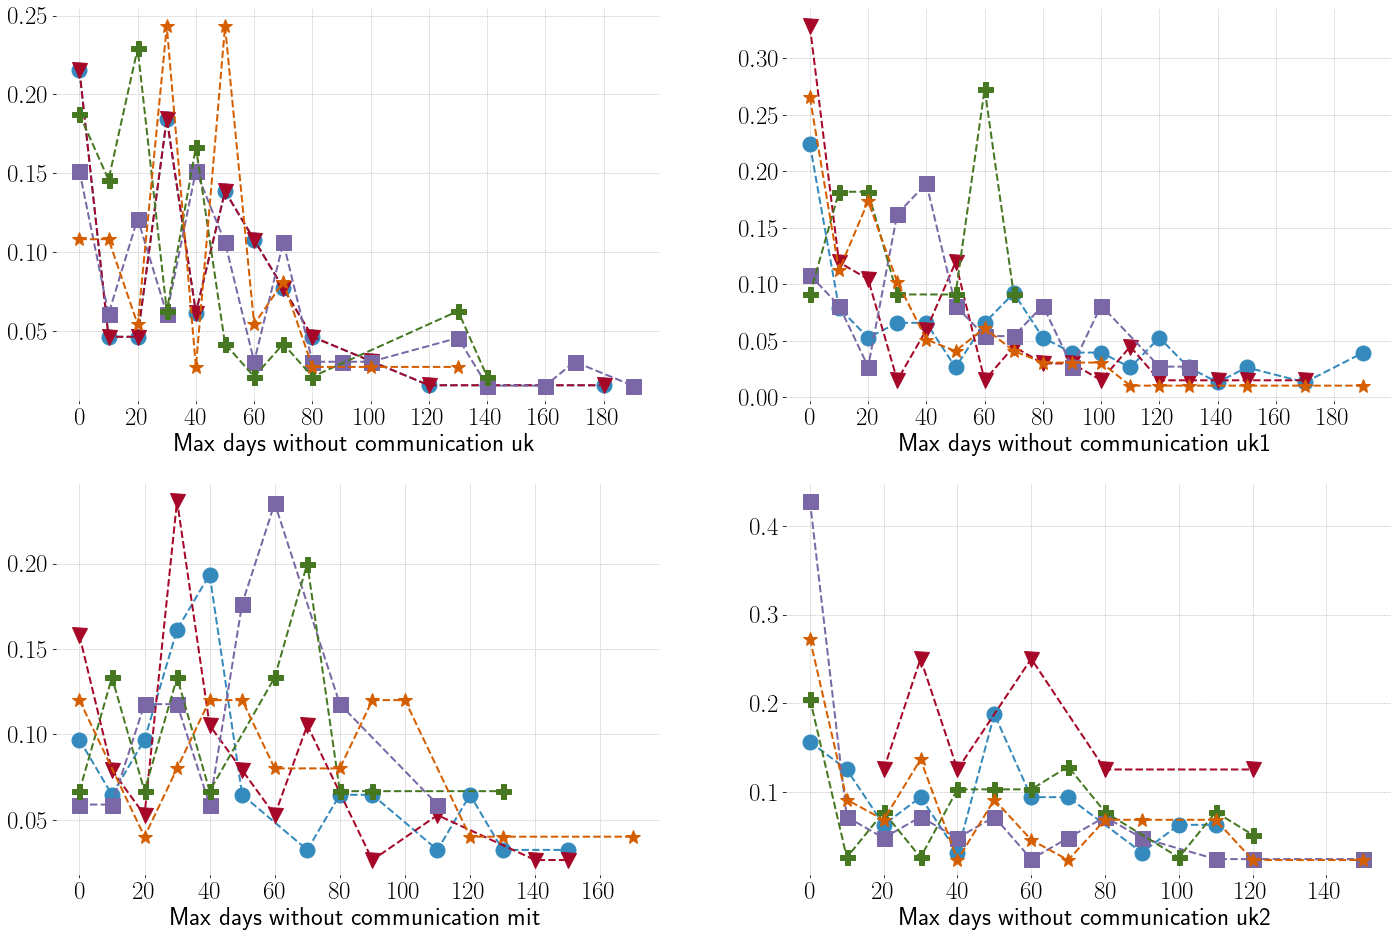

In [35]:
plt.figure(figsize=(24, 16))
p = 1
for c in ['uk', 'uk1', 'mit', 'uk2']:
    plt.subplot(2,2,p)
    plt.xlabel(f"Max days without communication {c}")
    plt.xticks(range(0, 200, 20))
    egos = list(nocommmax[c].keys())
    sample = np.random.choice(egos, size=5)
    for e in range(len(sample)):
        df = nocommmax[c][sample[e]]
        plt.plot([x * 10 for x in df.index], df[0]/sum(df[0]), marker=markers[e], markersize=15, ls="--")
    p += 1

In [36]:
t0 = dt.datetime.now()
scatters = {}
for c in filt_pairs.keys():
    scatters[c] = []
    df = filt_pairs[c]
    lives = pc.lives_dictionary(unfiltered[c])
    for i in df.index:
        ego = df.at[i, 'ego']
        alter = df.at[i, 'alter']
        ell = lives[ego][alter]['ell']
        iemax = df.at[i, 'ie_max']
        scatters[c].append((iemax, ell))
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.556428


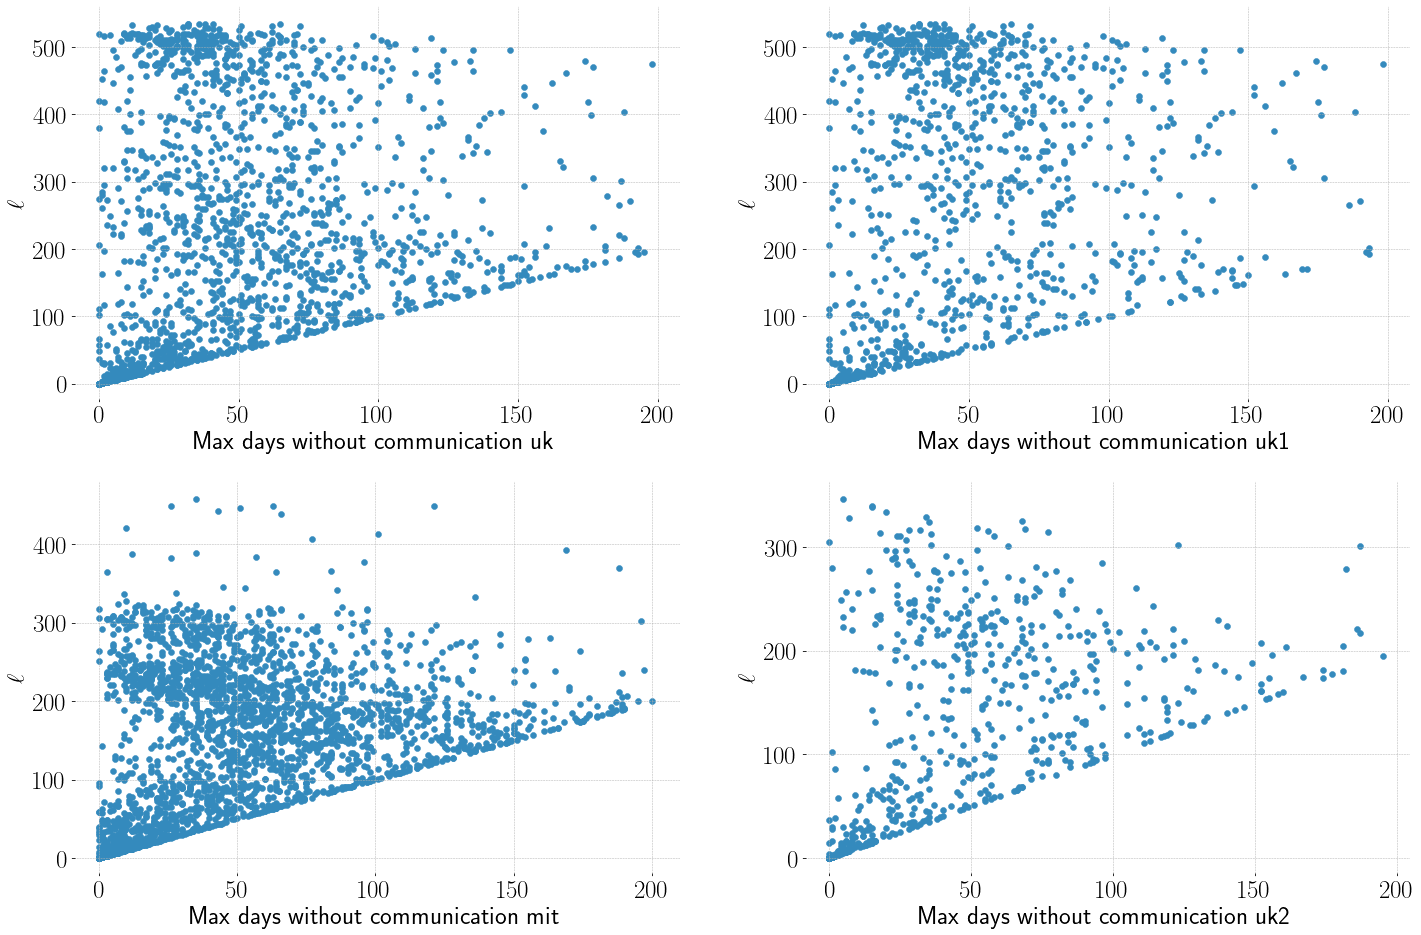

In [37]:
plt.figure(figsize=(24, 16))
p = 1
for c in ['uk', 'uk1', 'mit', 'uk2']:
    plt.subplot(2,2,p)
    plt.xlabel(f'Max days without communication {c}')
    plt.ylabel(r'$\ell$')
    plt.scatter([x[0] for x in scatters[c]], [y[1] for y in scatters[c]])
    p += 1

## Combining all alters (from all egos)

The idea is to create a single curve for all alters, one curve per cohort

In [38]:
maxieall = {}
for c in ['uk', 'mit']:
    H = {}
    df = filt_pairs[c]
    for d in df['ie_max']:
        H[d] = H.get(d, 0) + 1
    maxieall[c] = pd.DataFrame.from_dict(H, orient='index').sort_index()

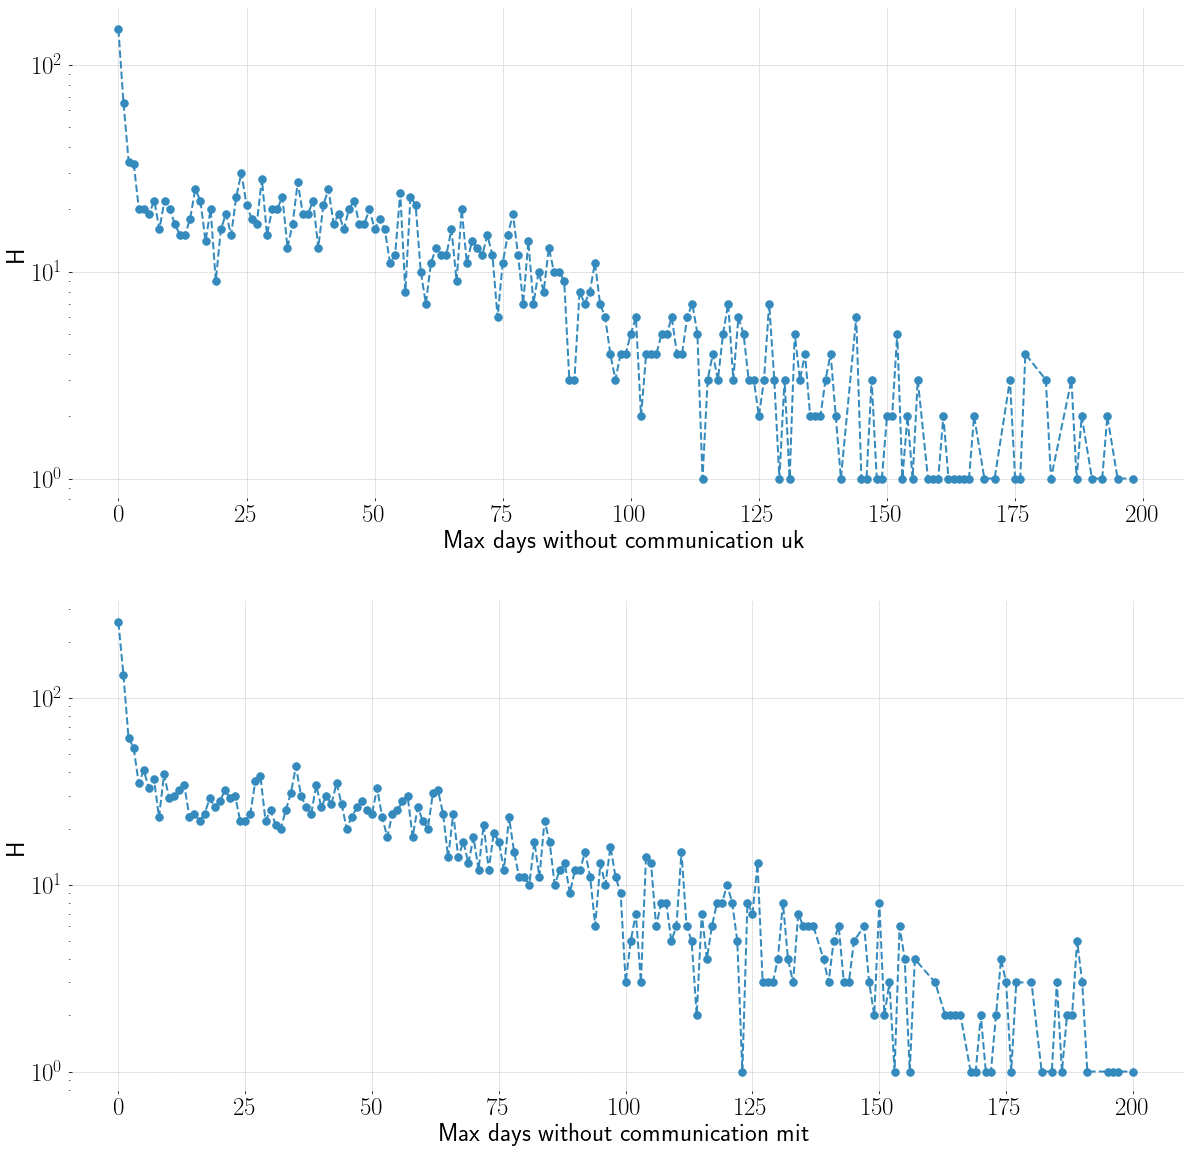

In [39]:
plt.figure(figsize=(20, 20))
p = 1
for c in maxieall.keys():
    plt.subplot(2, 1, p)
    plt.xlabel(f"Max days without communication {c}")
    plt.ylabel("H")
    plt.semilogy()
    plt.plot(maxieall[c].index, maxieall[c][0], ".", markersize=15, ls="--")
    p += 1

In [40]:
for c in maxieall.keys():
    df = maxieall[c]
    df['pdf'] = df[0] / sum(df[0])
    df['cdf'] = df['pdf'].cumsum()

In [41]:
for p in range(4):
    print(p % 2)

0
1
0
1


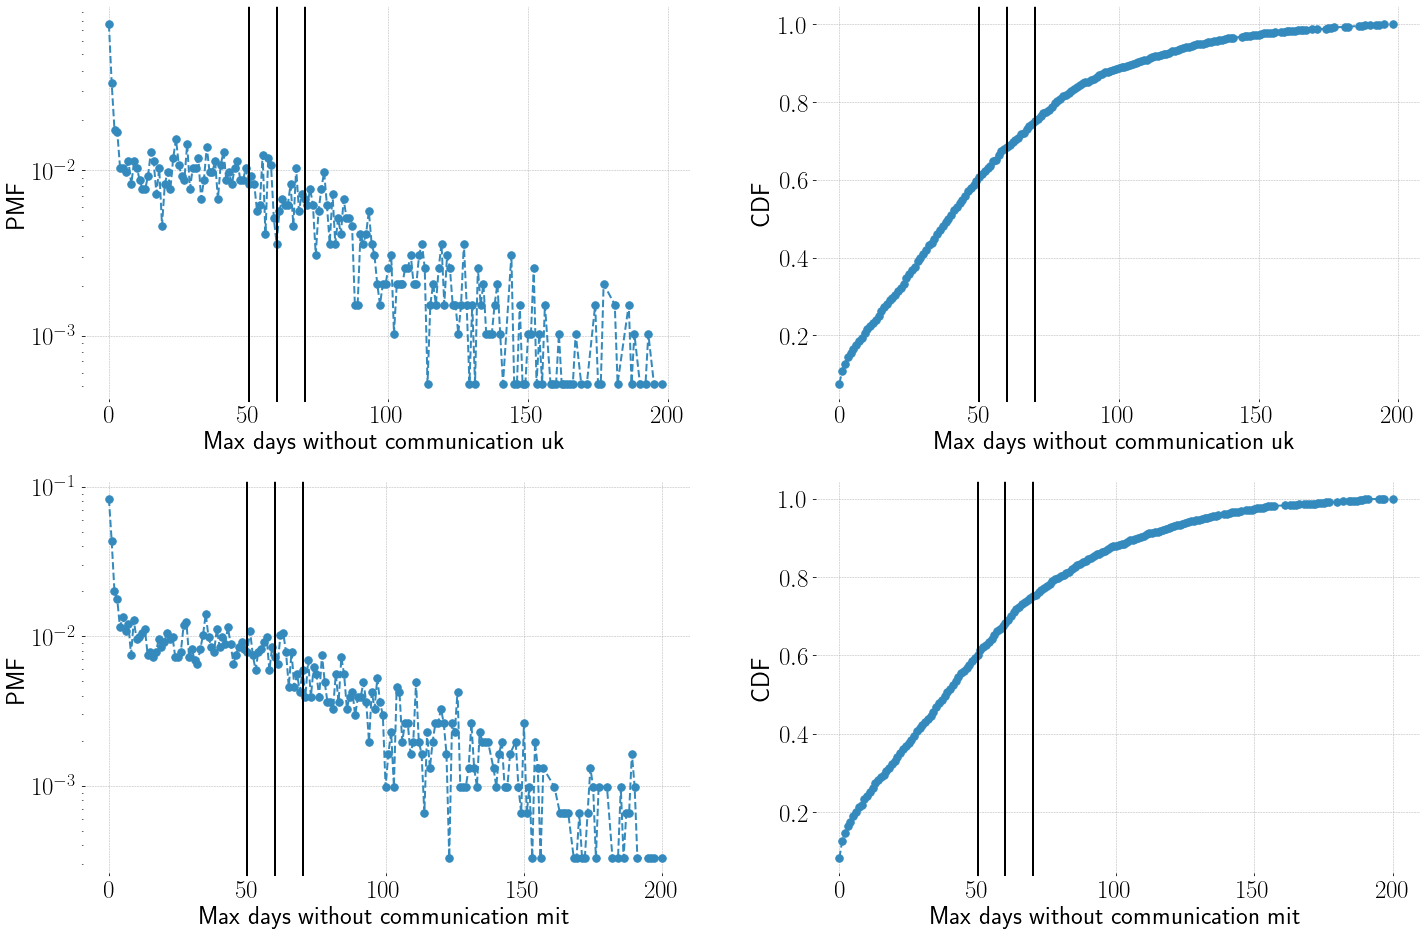

In [42]:
plt.figure(figsize=(24, 16))
for p in range(4):
    plt.subplot(2,2, p + 1)
    plt.xlabel(f"Max days without communication {['uk', 'mit'][p // 2]}")
    plt.ylabel(f"{['PMF', 'CDF'][p%2]}")
    df = maxieall[['uk', 'mit'][p//2]]
    if p % 2 == 0:
        plt.semilogy()
        plt.plot(df.index, df['pdf'], ".", markersize=15, ls="--")
    else:
        plt.plot(df.index, df['cdf'], ".", markersize=15, ls="--")
    for x in [50, 60, 70]:
        plt.axvline(x, color="black")

Now I'll fit a regression line from max days without communication 4 to 60

In [43]:
df = maxieall['uk']
df1 = df.loc[(df.index >= 4) & (df.index <= 60)]
y = np.array(df1['cdf'])
x = np.array(df1.index)
x = sm.add_constant(x)

model = sm.OLS(y, x)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.904e+04
Date:                Sun, 08 Aug 2021   Prob (F-statistic):           4.70e-85
Time:                        17:12:39   Log-Likelihood:                 222.47
No. Observations:                  57   AIC:                            -440.9
Df Residuals:                      55   BIC:                            -436.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1163      0.001     80.731      0.000       0.113       0.119
x1             0.0097      4e-05    242.983      0.000       0.010       0.010
==============================================================================
Omnibus:                        8.852   Durbin-Watson:                   0.245
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.244
Skew:                          -0.878   Prob(JB):                       0.0162
Kurtosis:                       3.625   Cond. No.                         78.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
result.params[0]

0.11625278785156447

In [45]:
result.rsquared

0.999069309804257

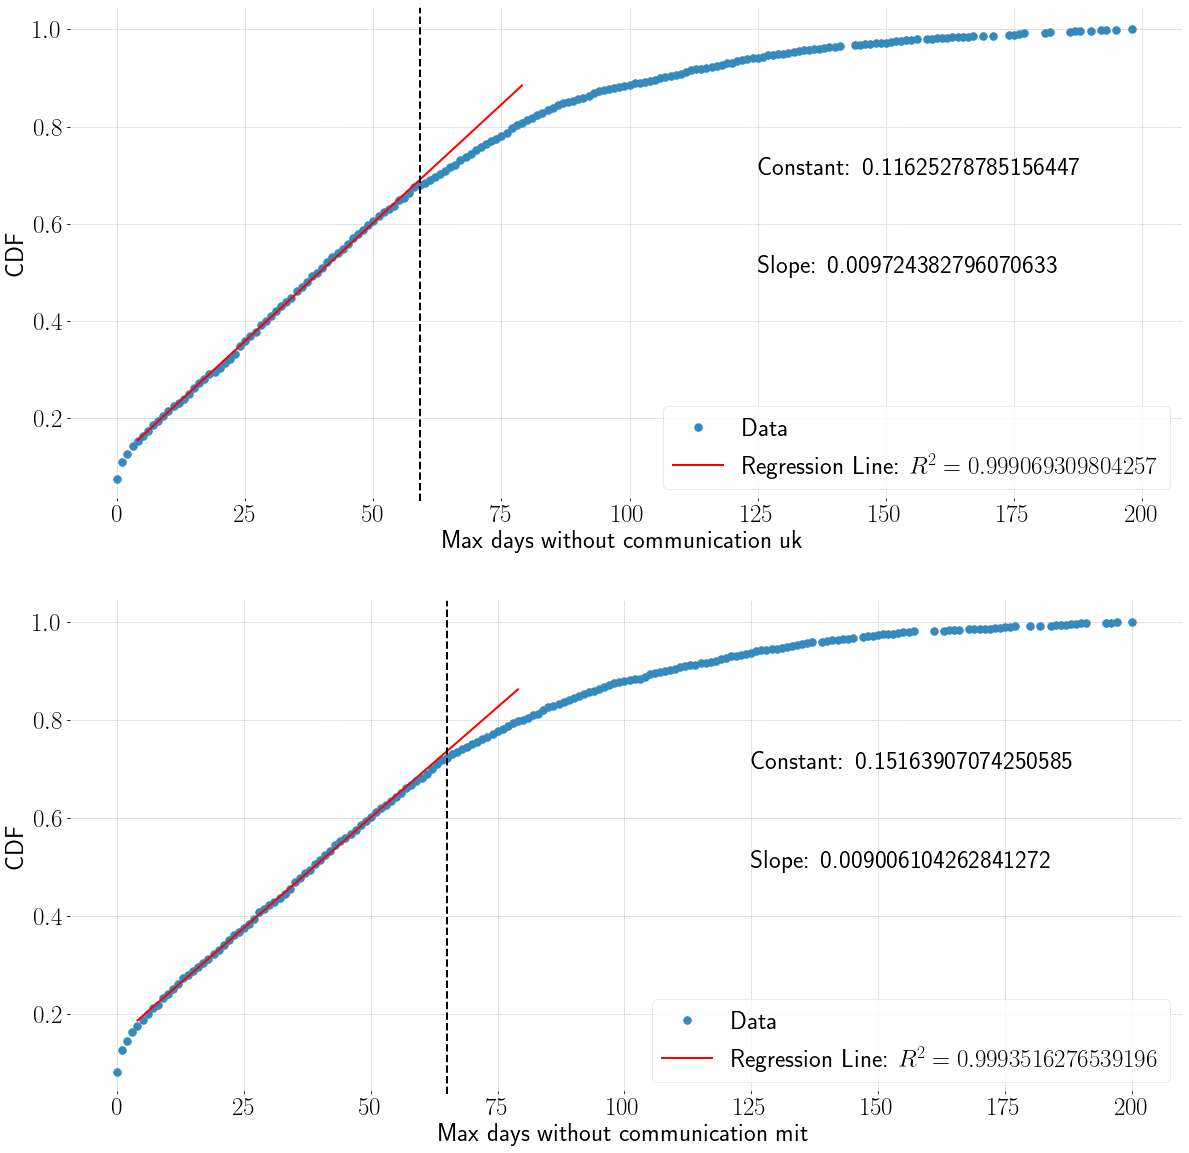

In [46]:
plt.figure(figsize=(20, 20))
p = 0
for c in ['uk', 'mit']:
    plt.subplot(2,1,p+1)
    plt.xlabel(f"Max days without communication {['uk', 'mit'][p]}")
    plt.ylabel("CDF")
    df = maxieall[c]
    plt.plot(df.index, df['cdf'], ".", markersize=15, label="Data")
    df1 = df.loc[(df.index >= 4) & (df.index <= 60)]
    y = np.array(df1['cdf'])
    x = np.array(df1.index)
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    xplot = list(range(4, 80))
    yplot = [result.params[0] + (X * result.params[1]) for X in xplot]
    plt.plot(xplot, yplot, marker="", ls="-", lw=2, c="red", label=fr'Regression Line: $R^2 = {result.rsquared}$')
    plt.annotate(f'Constant: {result.params[0]}', (125, 0.7), fontsize=25)
    plt.annotate(f'Slope: {result.params[1]}', (125, 0.5), fontsize=25)
    if c == 'uk':
        plt.axvline(59, c="black", ls="--")
    else:
        plt.axvline(65, c="black", ls="--")
    plt.legend()
    p += 1

In [47]:
# maxieall = {}
# for c in ['uk1', 'uk2']:
#     H = {}
#     df = filt_pairs[c]
#     for d in df['ie_max']:
#         H[d] = H.get(d, 0) + 1
#     maxieall[c] = pd.DataFrame.from_dict(H, orient='index').sort_index()

In [48]:
# plt.figure(figsize=(20, 20))
# p = 1
# for c in maxieall.keys():
#     plt.subplot(2, 1, p)
#     plt.xlabel(f"Max days without communication {c}")
#     plt.ylabel("H")
#     plt.semilogy()
#     plt.plot(maxieall[c].index, maxieall[c][0], ".", markersize=15, ls="--")
#     p += 1

## Remove some pairs

The criteria used to remove pairs of ego-alter will be those whose $\ell$ is **at least** $x$ times the maximum period without communication

In [49]:
filt_pairs['uk'].head()

ego         alter  nij    k     n    ie_mean     ie_std  \
1450  C07800759255  C01142253731    8  497  2730  23.714286  17.185661   
1471  C07800759255  C07796835479   14  497  2730   2.153846   6.904248   
1481  C07800759255  C07854475855    5  497  2730  13.250000  13.645054   
1414  C07800759255  C01142074267    5  497  2730  14.750000  22.219080   
1488  C07800759255  C07875703295   15  497  2730  11.714286  24.028045   

         p-new  ie_max  
1450  1.000000    54.0  
1471  0.409597    26.0  
1481  1.000000    34.0  
1414  1.000000    53.0  
1488  1.000000    95.0

In [50]:
t0 = dt.datetime.now()
censored = {}
for c in ['uk', 'mit']:
    lives = pc.lives_dictionary(filtered[c])
    censored[c] = {}
    df = filt_pairs[c]
    H = {}
    for d in df['ie_max']:
        H[d] = H.get(d, 0) + 1
    censored[c]['Uncensored'] = pd.DataFrame.from_dict(H, orient='index').sort_index()
    censored[c]['Uncensored']['p'] = censored[c]['Uncensored'][0] / sum(censored[c]['Uncensored'][0])
    for x in [1.5, 2, 2.5, 3]:
        censored[c][x] = {}
        H = {}
        for i in df.index:
            ego = df.at[i, 'ego']
            alter = df.at[i, 'alter']
            ell = lives[ego][alter]['ell']
            maxie = df.at[i, 'ie_max']
            if ell >= (x * maxie):
                H[maxie] = H.get(maxie, 0) + 1
        censored[c][x] = pd.DataFrame.from_dict(H, orient='index').sort_index()
        censored[c][x]['p'] = censored[c][x][0] / sum(censored[c][x][0])
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.297489


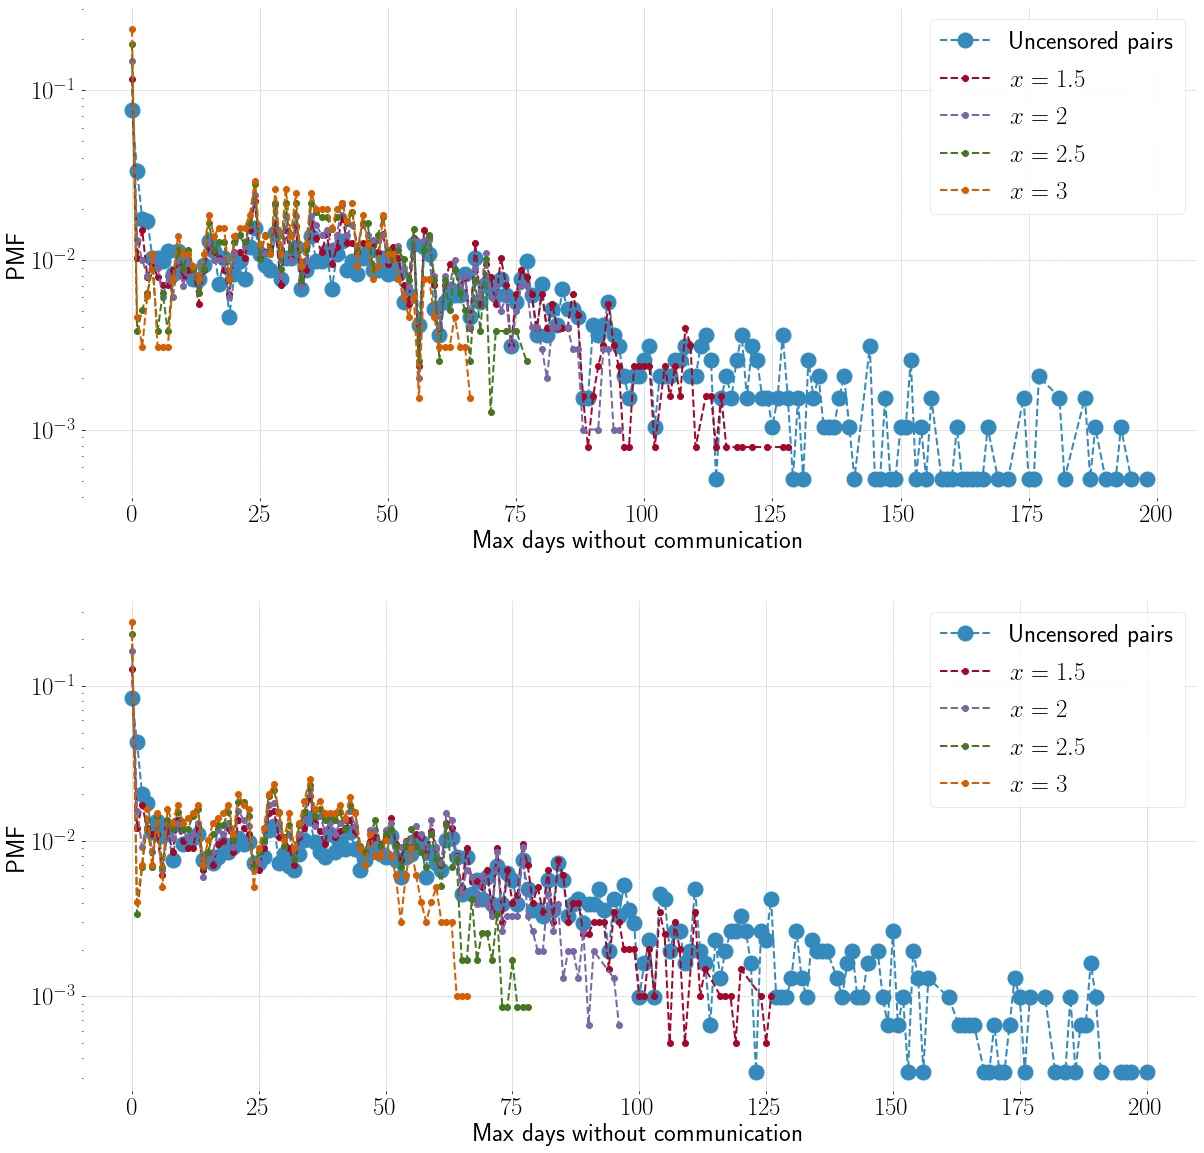

In [51]:
plt.figure(figsize=(20, 20))
for p in range(2):
    plt.subplot(2, 1, p+1)
    plt.xlabel("Max days without communication")
    plt.ylabel("PMF")
    plt.semilogy()
    cohorts = ['uk', 'mit']
    ddd = censored[cohorts[p]]
    for x in ddd.keys():
        if x == 'Uncensored':
            plt.plot(ddd[x].index, ddd[x]['p'], "o-", markersize=15, ls="--", label="Uncensored pairs")
        else:
            plt.plot(ddd[x].index, ddd[x]['p'], ".-", markersize=12, ls="--", label=fr'$x = {x}$')
    plt.legend()

In [52]:
censored['uk'].keys()

dict_keys(['Uncensored', 1.5, 2, 2.5, 3])

In [53]:
for x in range(10):
    print(x % 2)

0
1
0
1
0
1
0
1
0
1


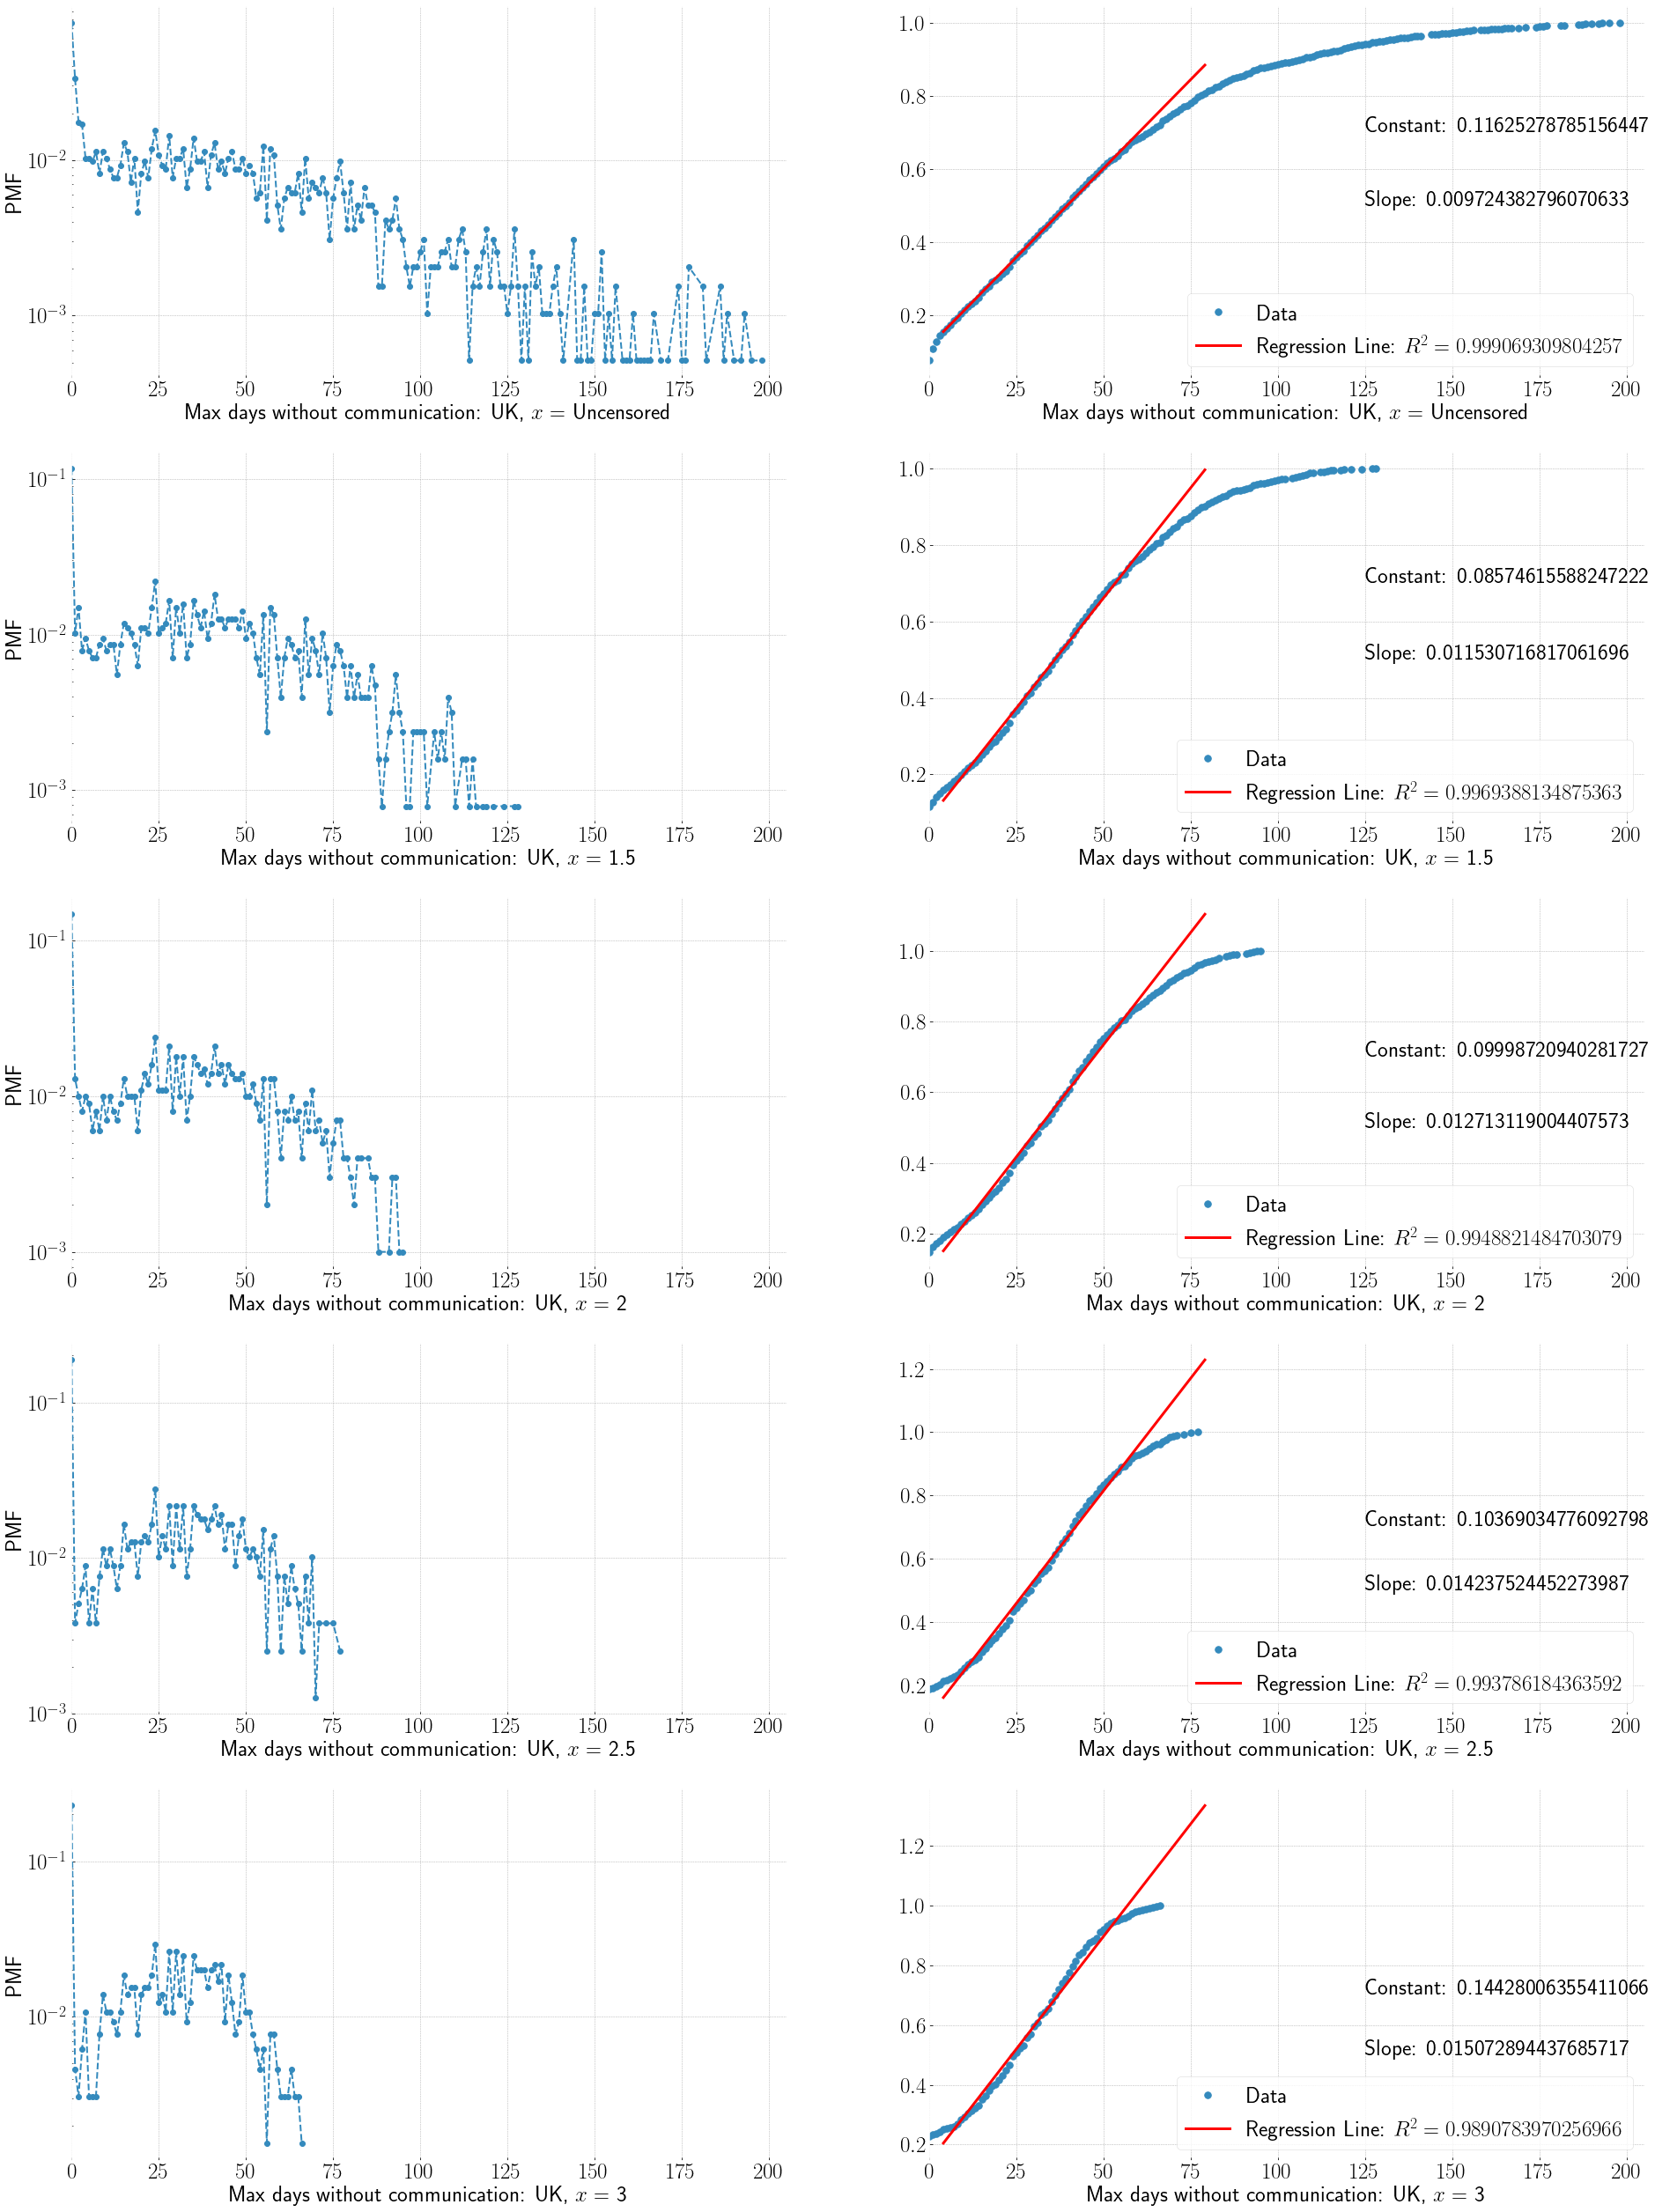

In [54]:
plt.figure(figsize=(32, 45))
keys = list(censored['uk'].keys())
for x in range(10):
    df = censored['uk'][keys[x//2]]
    df['c'] = df['p'].cumsum()
    plt.subplot(5, 2, x + 1)
    plt.xlabel(fr"Max days without communication: UK, $x = $ {keys[x//2]}")
    if x % 2 == 0:
        plt.semilogy()
        plt.xlim(0, 205)
        plt.ylabel("PMF")
        plt.plot(df.index, df['p'], "o-", ls="--")
    else:
        plt.xlim(0, 205)
        plt.plot(df.index, df['c'], ".", markersize=15, label="Data")
        df1 = df.loc[(df.index >= 4) & (df.index <= 60)]
        Y = np.array(df1['c'])
        X = np.array(df1.index)
        X = sm.add_constant(X)
        model = sm.OLS(Y, X)
        result = model.fit()
        xplot = list(range(4, 80))
        yplot = [result.params[0] + (XX * result.params[1]) for XX in xplot]
        plt.plot(xplot, yplot, marker="", ls="-", lw=3, c="red", label=fr'Regression Line: $R^2 = {result.rsquared}$')
        plt.annotate(f'Constant: {result.params[0]}', (125, 0.7), fontsize=25)
        plt.annotate(f'Slope: {result.params[1]}', (125, 0.5), fontsize=25)
        plt.legend()

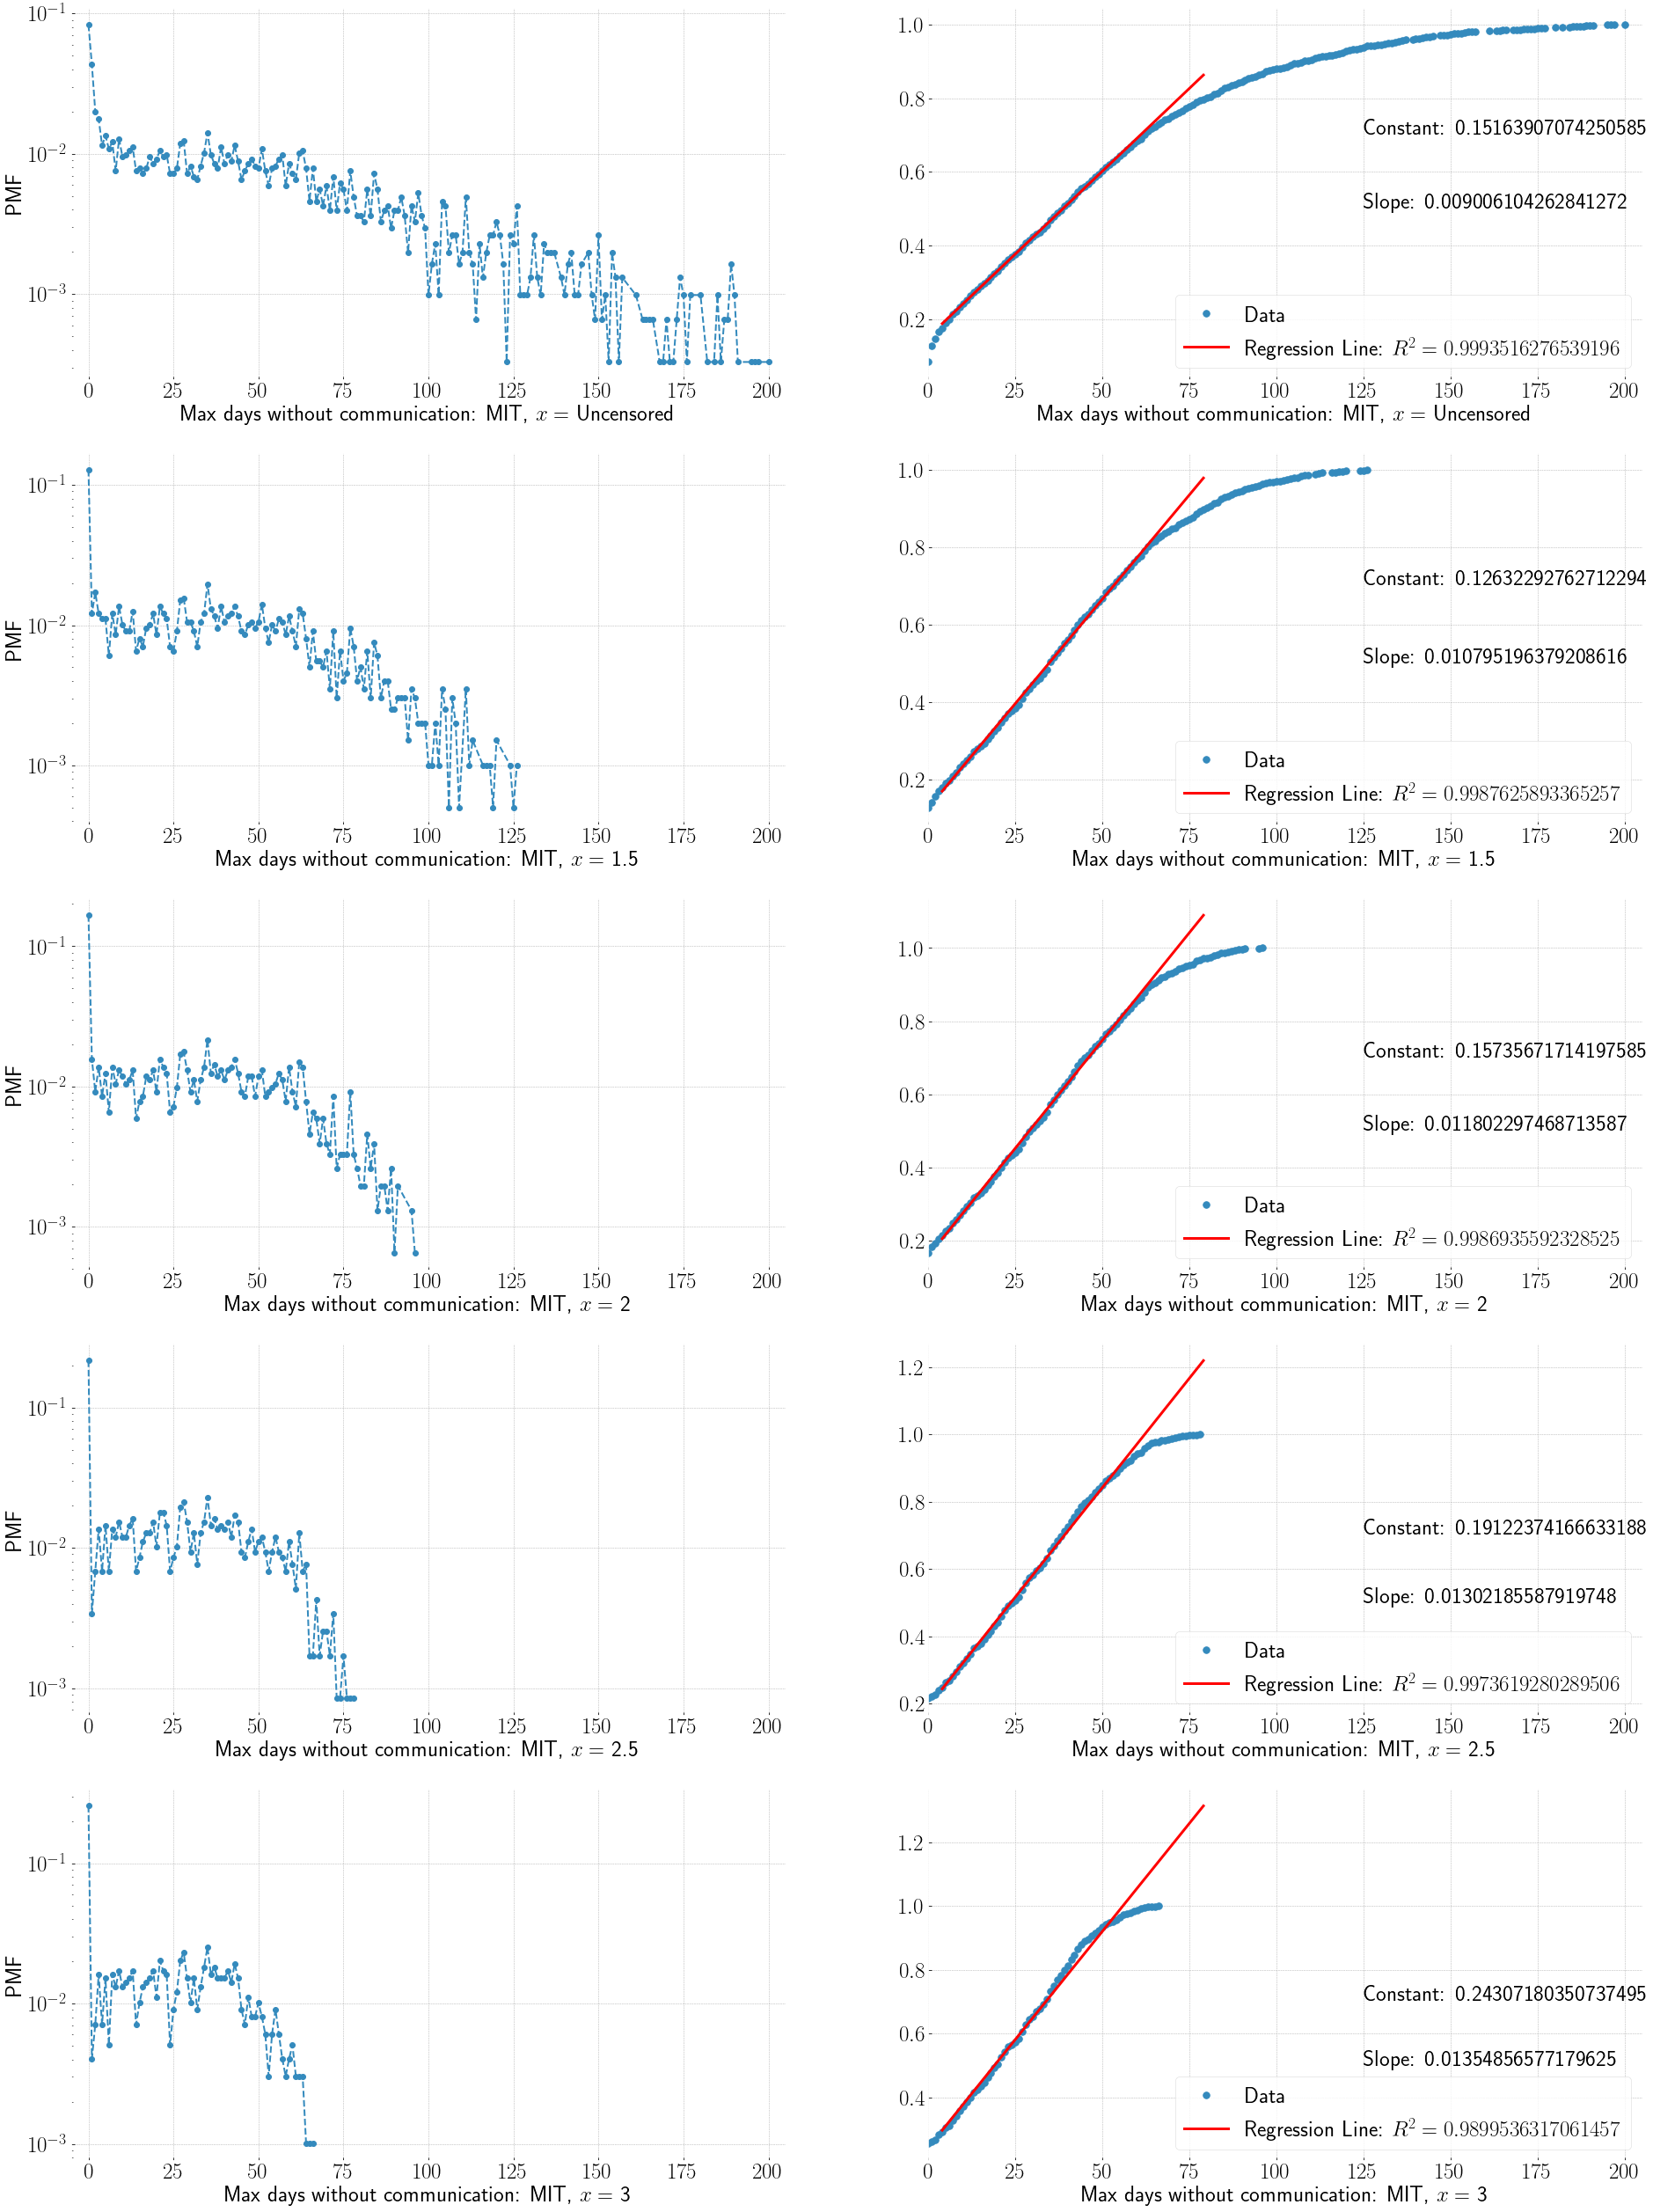

In [55]:
plt.figure(figsize=(32, 45))
keys = list(censored['mit'].keys())
for x in range(10):
    df = censored['mit'][keys[x//2]]
    df['c'] = df['p'].cumsum()
    plt.subplot(5, 2, x + 1)
    plt.xlabel(fr"Max days without communication: MIT, $x = $ {keys[x//2]}")
    plt.xlim(-5, 205)
    if x % 2 == 0:
        plt.semilogy()
        plt.ylabel("PMF")
        plt.plot(df.index, df['p'], "o-", ls="--")
    else:
        plt.xlim(0, 205)
        plt.plot(df.index, df['c'], ".", markersize=15, label="Data")
        df1 = df.loc[(df.index >= 4) & (df.index <= 60)]
        Y = np.array(df1['c'])
        X = np.array(df1.index)
        X = sm.add_constant(X)
        model = sm.OLS(Y, X)
        result = model.fit()
        xplot = list(range(4, 80))
        yplot = [result.params[0] + (XX * result.params[1]) for XX in xplot]
        plt.plot(xplot, yplot, marker="", ls="-", lw=3, c="red", label=fr'Regression Line: $R^2 = {result.rsquared}$')
        plt.annotate(f'Constant: {result.params[0]}', (125, 0.7), fontsize=25)
        plt.annotate(f'Slope: {result.params[1]}', (125, 0.5), fontsize=25)
        plt.legend()

## Scatterplot: biggest gap and number of calls

In [56]:
censored['uk'][1.5]

0         p         c
0.0    148  0.116719  0.116719
1.0     13  0.010252  0.126972
2.0     19  0.014984  0.141956
3.0     10  0.007886  0.149842
4.0     12  0.009464  0.159306
...    ...       ...       ...
119.0    1  0.000789  0.996845
121.0    1  0.000789  0.997634
124.0    1  0.000789  0.998423
127.0    1  0.000789  0.999211
128.0    1  0.000789  1.000000

[121 rows x 3 columns]

In [57]:
t0 = dt.datetime.now()
censored2 = {}
for c in ['uk', 'mit']:
    df = filt_pairs[c]
    lives = pc.lives_dictionary(filtered[c])
    censored2[c] = {}
    censored2[c]['Uncensored'] = [(x, y) for x, y in zip(df['nij'], df['ie_max'])]
    for X in [1.5, 2, 2.5, 3]:
        censored2[c][X] = []
        for i in df.index:
            ego = df.at[i, 'ego']
            alter = df.at[i, 'alter']
            maxie = df.at[i, 'ie_max']
            nij = df.at[i, 'nij']
            ell = lives[ego][alter]['ell']
            if ell >= (X * maxie):
                censored2[c][X].append((nij, maxie))
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.338780


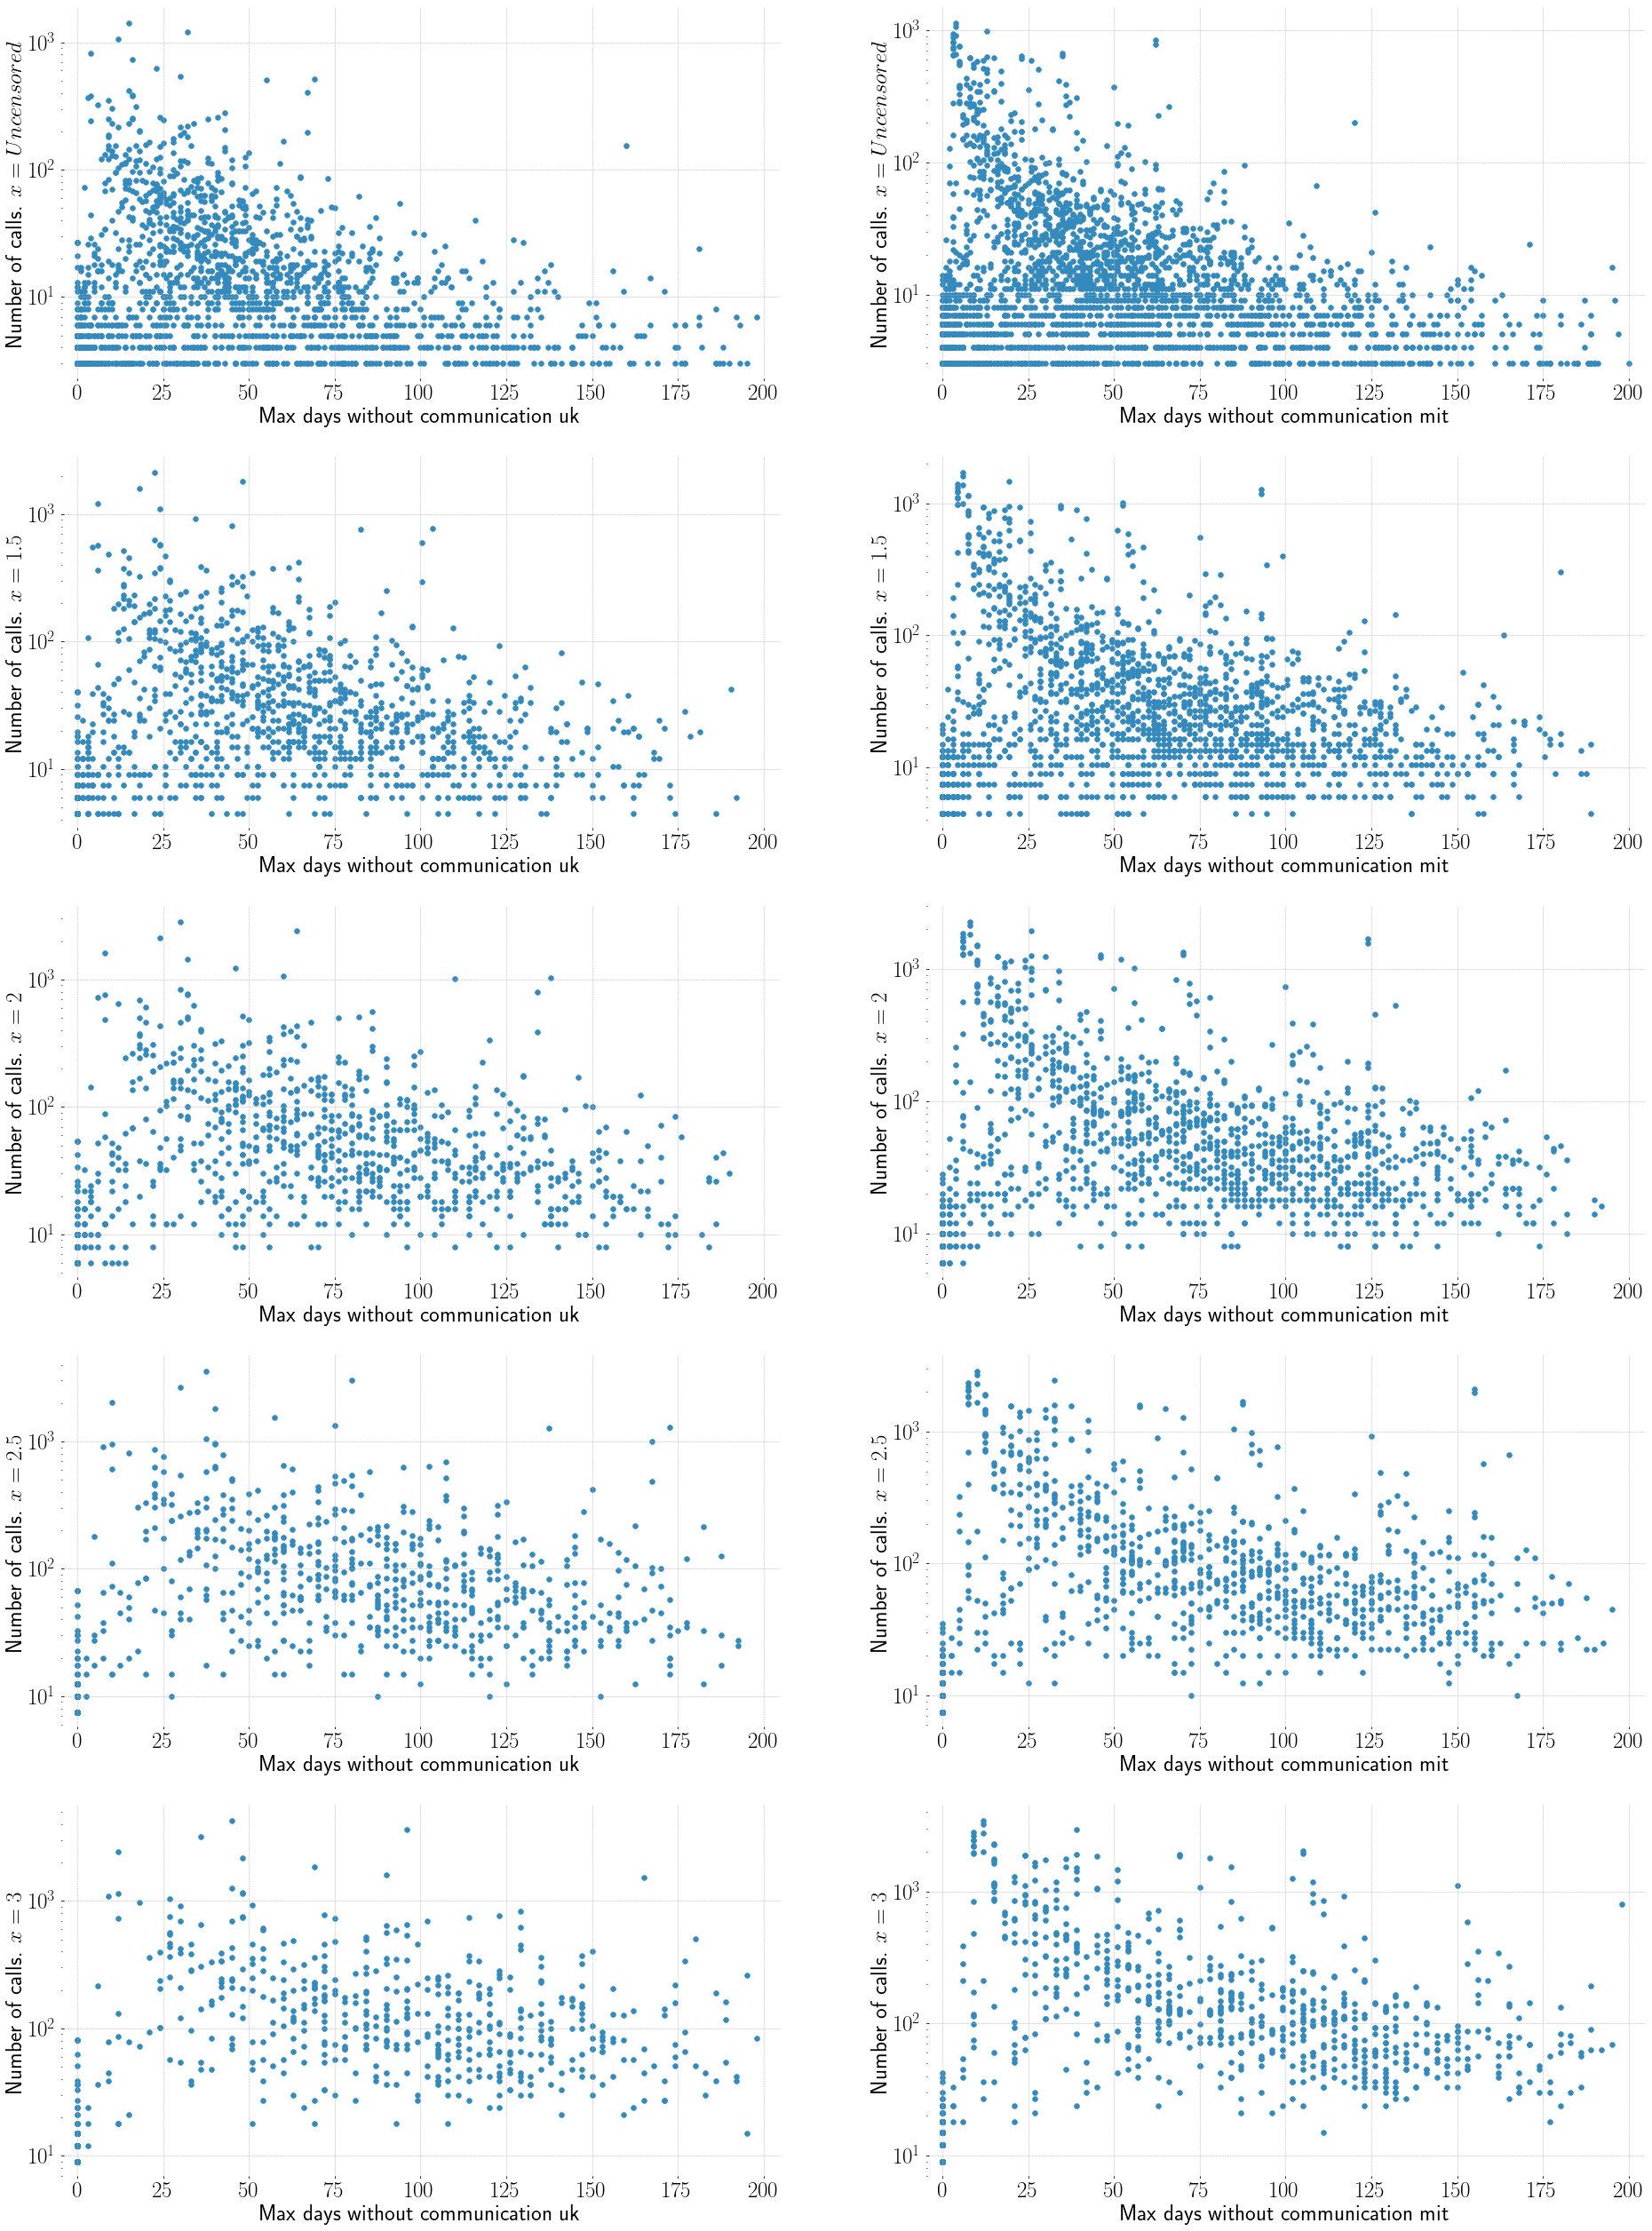

In [58]:
plt.figure(figsize=(32, 45))
cohorts = ['uk', 'mit']
keys = list(censored2['uk'].keys())
for p in range(10):
    plt.subplot(5,2,p + 1)
    plt.xlabel(f"Max days without communication {cohorts[p%2]}")
    plt.ylabel(fr"Number of calls. $x = {keys[p//2]}$")
    plt.xlim(-5, 205)
    plt.semilogy()
    df = censored2[cohorts[p%2]][keys[p//2]]
    if keys[p//2] != 'Uncensored':
        plt.scatter([(x[1] * keys[p//2]) for x in df], [(y[0] * keys[p//2]) for y in df])
    else:
        plt.scatter([x[1] for x in df], [y[0] for y in df])    

In [59]:
a = [1, 2, 3]
b = [10, 20, 30]
c = [(x, y) for x, y in zip(a, b)]
c

[(1, 10), (2, 20), (3, 30)]

In [60]:
filt_pairs['uk'].head()

ego         alter  nij    k     n    ie_mean     ie_std  \
1450  C07800759255  C01142253731    8  497  2730  23.714286  17.185661   
1471  C07800759255  C07796835479   14  497  2730   2.153846   6.904248   
1481  C07800759255  C07854475855    5  497  2730  13.250000  13.645054   
1414  C07800759255  C01142074267    5  497  2730  14.750000  22.219080   
1488  C07800759255  C07875703295   15  497  2730  11.714286  24.028045   

         p-new  ie_max  
1450  1.000000    54.0  
1471  0.409597    26.0  
1481  1.000000    34.0  
1414  1.000000    53.0  
1488  1.000000    95.0

(array([1.415e+03, 2.020e+02, 9.400e+01, 5.500e+01, 4.500e+01, 2.600e+01,
        1.300e+01, 1.500e+01, 1.300e+01, 8.000e+00, 1.000e+01, 4.000e+00,
        3.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 6.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

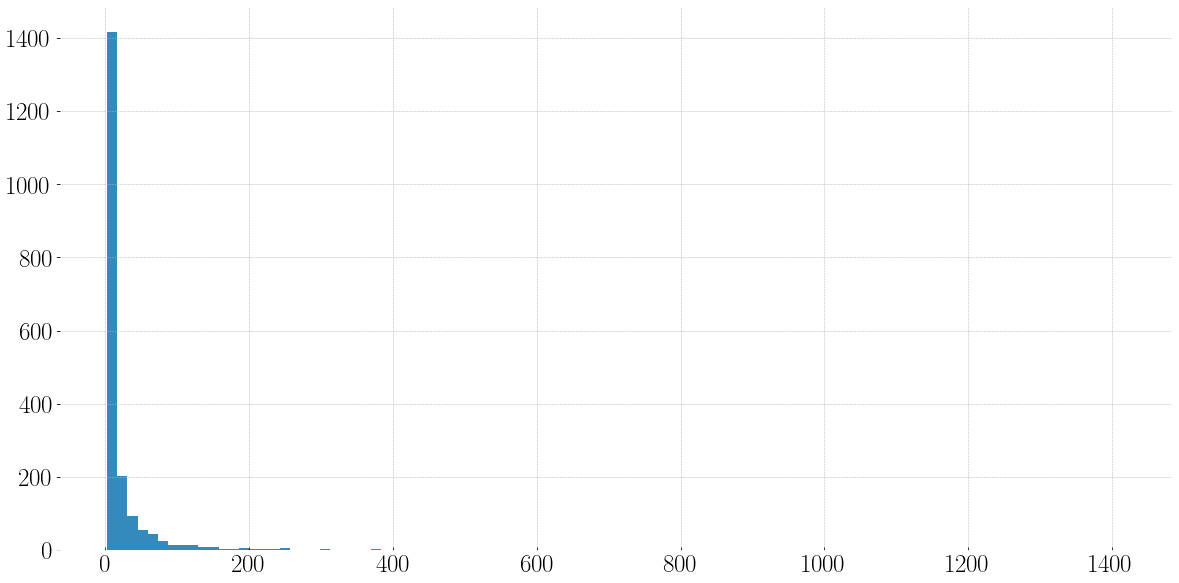

In [61]:
plt.hist(filt_pairs['uk']['nij'], bins = 100)

# Change limits in data

Considering that we want to capture ego-alter's relationship, but also its *periods of silence*; the limitation on $\ell \leq 200$ does not make sense anymore. What I'll do is to use the unfiltered dataset as a starting point. The filter I'll introduce is to remove some alters with *low traffic* (number of phone calls). To decide how many, I'll plot de histogram.

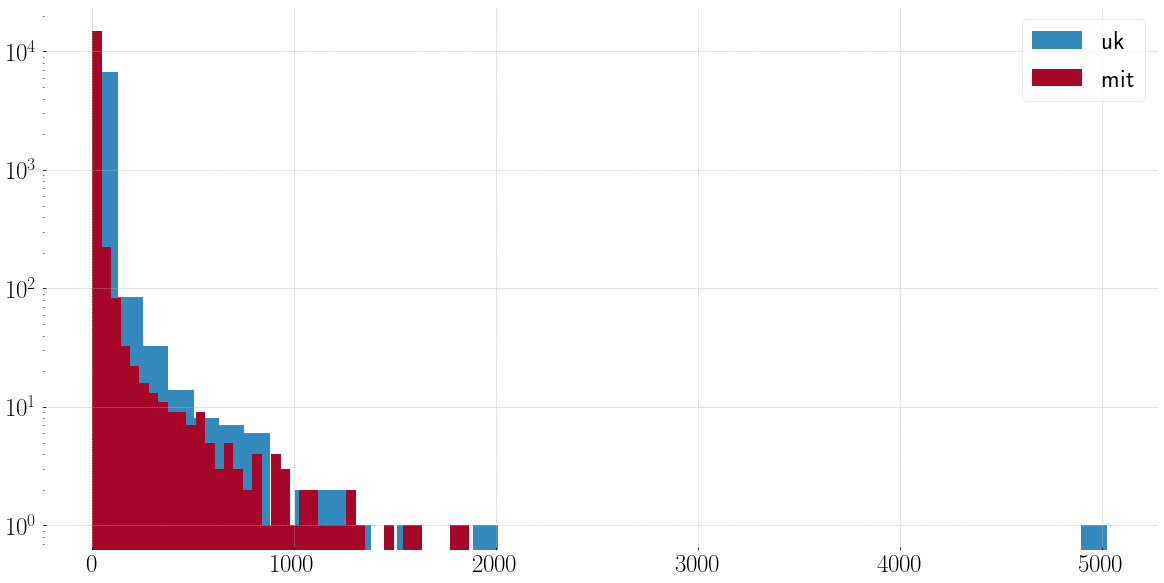

In [152]:
punf = {}
for c in ['uk', 'mit']:
    punf[c] = pc.pairs(unfiltered[c])
    #plt.loglog()
    plt.hist(punf[c]['nij'], bins=40, log=True, label=c)
    plt.legend()

Since things are not so clear, I'll start by removing the first 30 days of each ego and then check how many alter I'll lose removing activities of less than 3, 4, $\ldots$

In [153]:
calls8 = {}
for c in punf.keys():
    uno = unfiltered[c].groupby('ego')[['uclock']].min()
    dos = pd.DataFrame()
    for ego in unfiltered[c]['ego'].unique():
        df = unfiltered[c].loc[unfiltered[c]['ego'] == ego]
        minday = uno.loc[ego]['uclock'] + 30
        df1 = df.loc[df['uclock'] >= minday]
        dos = dos.append(df1).reset_index(drop=True)
    old = len(unfiltered[c])
    calls8[c] = dos
    print(f'{c} lost {old - len(calls8[c])} calls')

uk lost 5733 calls
mit lost 19098 calls


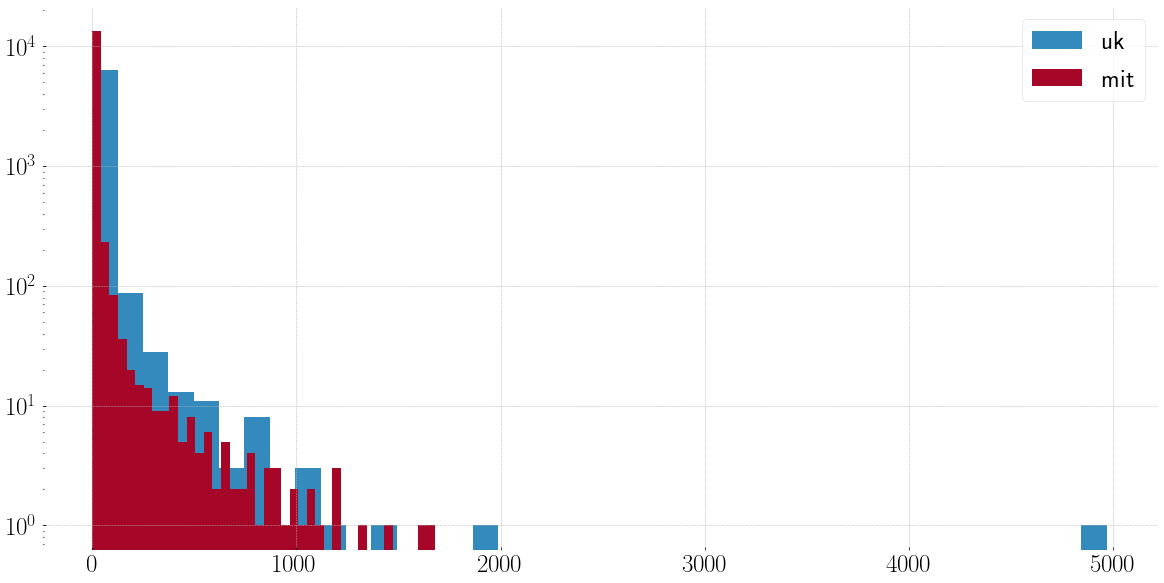

In [154]:
punf = {}
for c in ['uk', 'mit']:
    punf[c] = pc.pairs(calls8[c])
    #plt.loglog()
    plt.hist(punf[c]['nij'], bins=40, log=True, label=c)
    plt.legend()

In [81]:
loss = {}
for c in punf.keys():
    loss[c] = pd.DataFrame()
    df = punf[c]
    old = len(df)
    for i in range(4, 31):
        df2 = df.loc[df['nij'] >= i]
        loss[c].at[i, 'n'] = len(df2)
        loss[c].at[i, 'perc'] = 1 - (len(df2) / old)

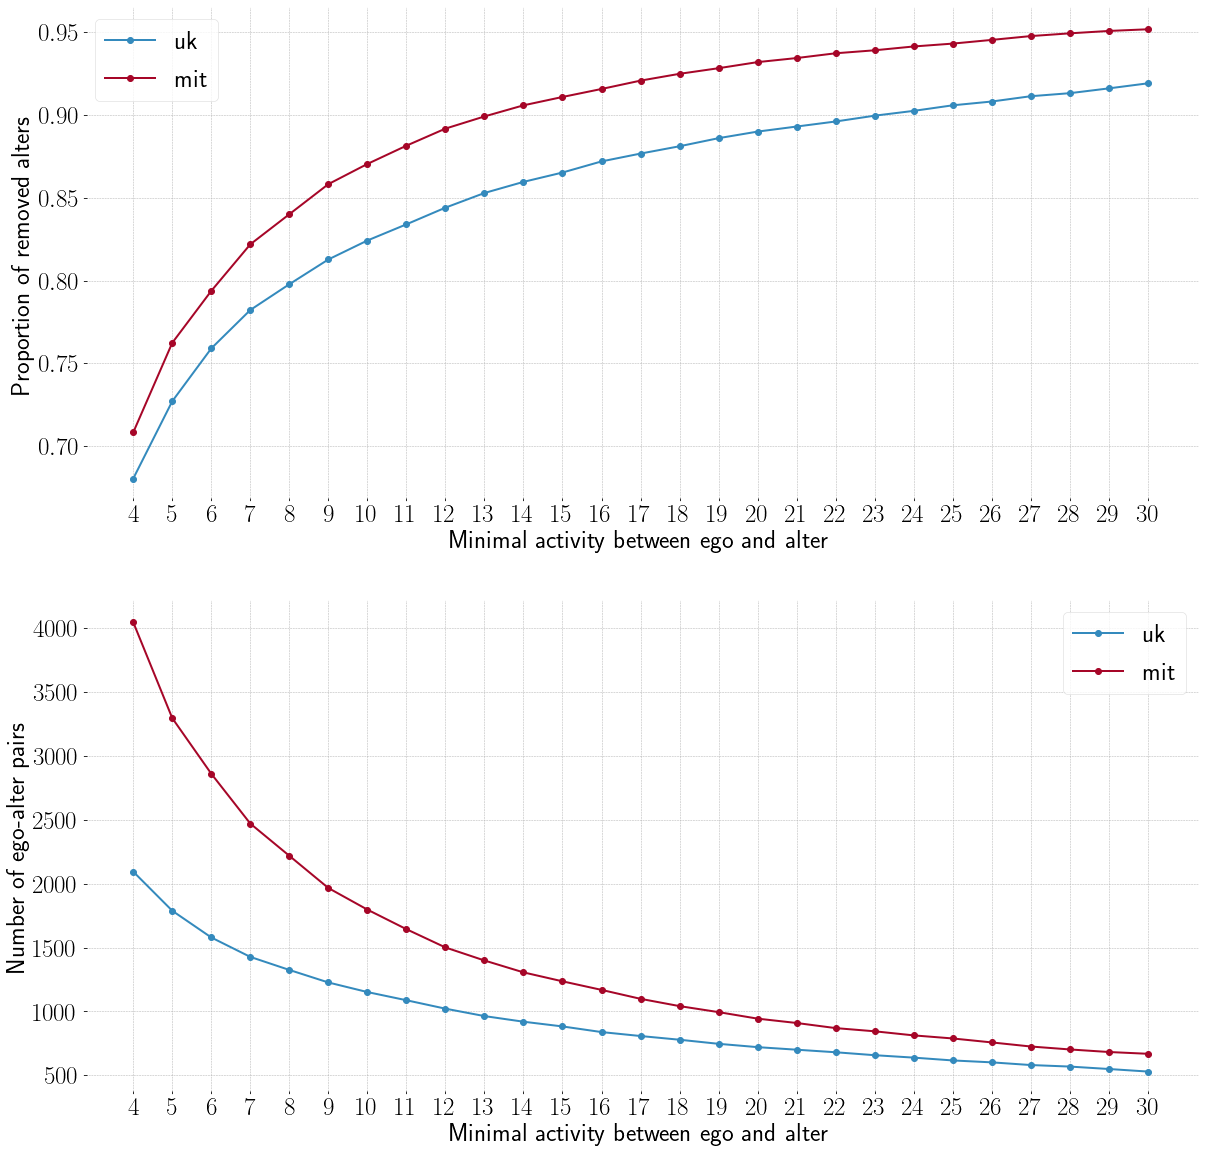

In [84]:
plt.figure(figsize=(20, 20))
plt.subplot(211)
plt.xticks(range(4, 31))
plt.xlabel("Minimal activity between ego and alter")
plt.ylabel("Proportion of removed alters")
for c in loss.keys():
    plt.plot(loss[c].index, loss[c]['perc'], "o-", label=f"{c}")
plt.legend()

plt.subplot(212)
plt.xticks(range(4, 31))
plt.xlabel("Minimal activity between ego and alter")
plt.ylabel("Number of ego-alter pairs")
for c in loss.keys():
    plt.plot(loss[c].index, loss[c]['n'], "o-", label=f"{c}")
plt.legend()

# Back to UK
I need to go back to the questionnaires and check if I can identify within the family relkationships those who are parents, siblings, etc. The first step is to import the data from the questionnaires.

In [85]:
import sys

# First, read the files and put them in a list
thefiles = os.listdir("../ukdata/egos_attributeSummaries/")

# now, remove everything that does not follow the structure 'egoxx_...'
for i in thefiles:
    if i[5] != '_':
        thefiles.remove(i)

# I need the following lines because MacOS creates a .DS_Store file
if sys.platform == 'darwin':
    thefiles.remove('.DS_Store')
        
# Next, a list with just the number of the egos.
theindices = [int(i[3:5]) for i in thefiles]

# And finally, everything into a dictionary.
alterinfo = {}
colnames = ['alterid', 'male', 'related', 'sameGen', 'ec1', 'ec2', 'ec3', 'alter_number1', 'alter_number2', 'alter_number3', 'alter_number4']
for i in range(len(thefiles)):
    alterinfo[theindices[i]] = pd.read_csv(f"../ukdata/egos_attributeSummaries/{thefiles[i]}", header=None, sep=" ", names=colnames, na_values=-999, 
                                           dtype={'alter_number1' : 'str', 'alter_number2' : 'str', 'alter_number3' : 'str', 'alter_number4' : 'str'})

In [156]:
alterinfo[13]

alterid  male  related  sameGen  ec1   ec2  ec3 alter_number1  \
0          0   0.0      0.0      NaN  9.0  10.0  0.0      00643415   
1          1   1.0      0.0      NaN  8.0  10.0  0.0      70136770   
2          2   1.0      0.0      NaN  8.0  10.0  0.0      92658339   
3          3   1.0      0.0      NaN  7.0  10.0  0.0      28746628   
4          4   1.0      0.0      NaN  6.0  10.0  0.0      29005350   
..       ...   ...      ...      ...  ...   ...  ...           ...   
373      373   NaN      NaN      NaN  NaN   NaN  NaN      74414160   
374      374   NaN      NaN      NaN  NaN   NaN  NaN      42767878   
375      375   NaN      NaN      NaN  NaN   NaN  NaN      86651035   
376      376   NaN      NaN      NaN  NaN   NaN  NaN      33105480   
377      377   NaN      NaN      NaN  NaN   NaN  NaN      00759255   

    alter_number2 alter_number3 alter_number4  
0             NaN           NaN           NaN  
1        42584544           NaN           NaN  
2             NaN           NaN           NaN  
3             NaN           NaN           NaN  
4             NaN           NaN           NaN  
..            ...           ...           ...  
373           NaN           NaN           NaN  
374           NaN           NaN           NaN  
375           NaN           NaN           NaN  
376           NaN           NaN           NaN  
377           NaN           NaN           NaN  

[378 rows x 11 columns]

In [148]:
thefiles = os.listdir("../ukdata/egos_alterNumbers/")
for i in thefiles:
    if i[5] != '_':
        thefiles.remove(i)
idx = [int(i[3:5]) for i in thefiles]
alterid = {}
for eid in range(len(idx)):
    df = pd.read_csv(f'../ukdata/egos_alterNumbers/{thefiles[eid]}', header=None, sep=" ", dtype={0: 'str'})
    tmp2 = {}
    for i in df.index:
        key = df.at[i, 0][-8:]
        val = df.at[i, 1]
        tmp2[key] = val
    alterid[idx[eid]] = tmp2        

In [108]:
t0 = dt.datetime.now()
pdf = punf['uk']
for i in pdf.index:
    ego = pdf.at[i, 'ego']
    ego2 = ego[-8:]
    alter = pdf.at[i, 'ego']
    alter2 = alter[-8:]
    tmp = eid.loc[eid['ego'] == ego2]
    if len(tmp) > 0:
        egoid = tmp['egoid'].iloc[0]
        pdf.at[i, 'ego_sex'] = tmp['ego_sex'].iloc[0]
        for j in tmp.index:
            alterx = tmp.at[j, 'alter']
            if alter2 == alterx:
                pdf.at[i, 'related'] = tmp.at[j, 'related']
                pdf.at[i, 'samegen'] = tmp.at[j, 'sameGen']
                if tmp.at[j, 'male'] == 1:
                    pdf.at[i, 'alter_sex'] = 'Male'
                elif tmp.at[j, 'male'] == 0:
                    pdf.at[i, 'alter_sex'] == 'Female'
print(f'Took {dt.datetime.now() - t0}')

Took 0:01:42.638805


In [160]:
egotags = {}
df = pd.read_pickle("egoid.pkl")
for ego in df['ego'].unique():
    df1 = df.loc[df['ego'] == ego]
    egotags[ego] = df1['egoid'].iloc[0]

In [169]:
count  = 0
df = punf['uk']
for i in df.index:
    ego = df.at[i, 'ego']
    ego2 = ego[-8:]
    alter = df.at[i, 'alter']
    alter2 = alter[-8:]
    etag = egotags.get(ego2, 'pikachu')
    if (etag != 'pikachu') and (etag in alterid.keys()):
        atag = alterid[etag].get(alter2, 'charmander')
        if atag != 'charmander':
            df2 = alterinfo[etag].loc[alterinfo[etag]['alterid'] == atag].reset_index(drop=True)
            df.at[i, 'related'] = df2['related'].iloc[0]
            df.at[i, 'samegen'] = df2['sameGen'].iloc[0]
            if df2['male'].iloc[0] == 1:
                df.at[i, 'alter_sex'] = 'Male'
            elif df2['male'].iloc[0] == 0:
                df.at[i, 'alter_sex'] = 'Female'

In [175]:
df = punf['uk']
for i in df.index:
    related = df.at[i, 'related']
    if (not pd.isna(related)) and (related == 1):
        samegen = df.at[i, 'samegen']
        asex = df.at[i, 'alter_sex']
        if (samegen == 0) and (asex == 'Female'):
            df.at[i, 'family'] = 'Mother'
        elif (samegen == 0) and (asex == 'Male'):
            df.at[i, 'family'] = 'Father'
        else:
            df.at[i, 'family'] = 'Other'
    else:
        df.at[i, 'family'] = 'No'

In [178]:
for ego in punf['uk']['ego'].unique():
    df = punf['uk'].loc[punf['uk']['ego'] == ego]
    tmp = df.loc[df['family'] == 'Mother']
    m = len(tmp)
    tmp = df.loc[df['family'] == 'Father']
    f = len(tmp)
    print(f'Ego {ego} has {m} mother(s) and {f} father(s)')

Ego C07800643466 has 0 mother(s) and 0 father(s)
Ego C07792658339 has 3 mother(s) and 3 father(s)
Ego C07814508939 has 0 mother(s) and 0 father(s)
Ego C07974937603 has 0 mother(s) and 1 father(s)
Ego C07800643277 has 0 mother(s) and 0 father(s)
Ego C07800759255 has 1 mother(s) and 4 father(s)
Ego C07792057901 has 3 mother(s) and 3 father(s)
Ego C07817280467 has 0 mother(s) and 0 father(s)
Ego C07800643415 has 3 mother(s) and 4 father(s)
Ego C07999103487 has 2 mother(s) and 0 father(s)
Ego C07800756371 has 1 mother(s) and 0 father(s)
Ego C07970136770 has 1 mother(s) and 1 father(s)
Ego C07896556837 has 1 mother(s) and 0 father(s)
Ego C07792058001 has 3 mother(s) and 3 father(s)
Ego C07855941005 has 4 mother(s) and 1 father(s)
Ego C07974937643 has 0 mother(s) and 0 father(s)
Ego C07890818114 has 2 mother(s) and 3 father(s)
Ego C07800650314 has 2 mother(s) and 1 father(s)
Ego C07896537661 has 2 mother(s) and 2 father(s)
Ego C07800755987 has 2 mother(s) and 2 father(s)
Ego C07792658311 has

In [192]:
df = punf['uk']
lives = pc.lives_dictionary(unfiltered['uk'])
for i in df.index:
    ego = df.at[i, 'ego']
    alter = df.at[i, 'alter']Mother
    df.at[i, 'ell'] = lives[ego][alter]['ell']

In [197]:
a = punf['uk'].loc[(punf['uk']['ego'] == 'C07792658339') & (punf['uk']['family'] == 'Mother')]
a

ego         alter  nij    k     n  related  samegen alter_sex  \
300  C07792658339  C07737205057  859  546  8889      1.0      0.0    Female   
314  C07792658339  C07756018659   52  546  8889      1.0      0.0    Female   
820  C07792658339  C01142433599   75  546  8889      1.0      0.0    Female   

     family    ell  
300  Mother  502.0  
314  Mother  511.0  
820  Mother  231.0

In [183]:
i = 'C07792658339'
egotags[i[-8:]]

14

In [198]:
for alter in a['alter']:
    a2 = alter[-8:]
    print(alterid[14][a2])

7
20
20


# Supplemental materials

I'll do all the checks here to put data in the suppllemental analysis for the paper. First, results from changing $T$

In [199]:
unfiltered.keys()

dict_keys(['mit', 'uk1', 'uk2', 'uk', 'all'])

In [200]:
callT = {}
df = unfiltered['all']
for T in [200, 300, 400]:
    callT[T] = df.loc[df['aclock'] <= T]

There is also the need to remove all alters that entered the study too late to be considered. By too late, we mean $\mathcal{T} - T$

In [202]:
for T in callT.keys():
    uno = pd.DataFrame()
    maxt = max(callT[T]['uclock'])
    for ego in callT[T]['ego'].unique():
        df = callT[T].loc[callT[T]['ego'] == ego]
        for alter in df['alter'].unique():
            df2 = df.loc[df['alter'] == alter]
            mint = min(df2['uclock'])
            if mint < (maxt - T):
                df2.loc[:, 'aclock'] = df2['uclock'] - mint
                uno = uno.append(df2).reset_index(drop=True)
    callT[T] = uno

/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [203]:
sup1 = {}
for T in callT.keys():
    dff = pc.get_f(callT[T], 'all', 10, 70)
    b = pc.get_b(dff, 'alpha')
    sup1[T] = pc.plot_g(b, 'alpha')

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


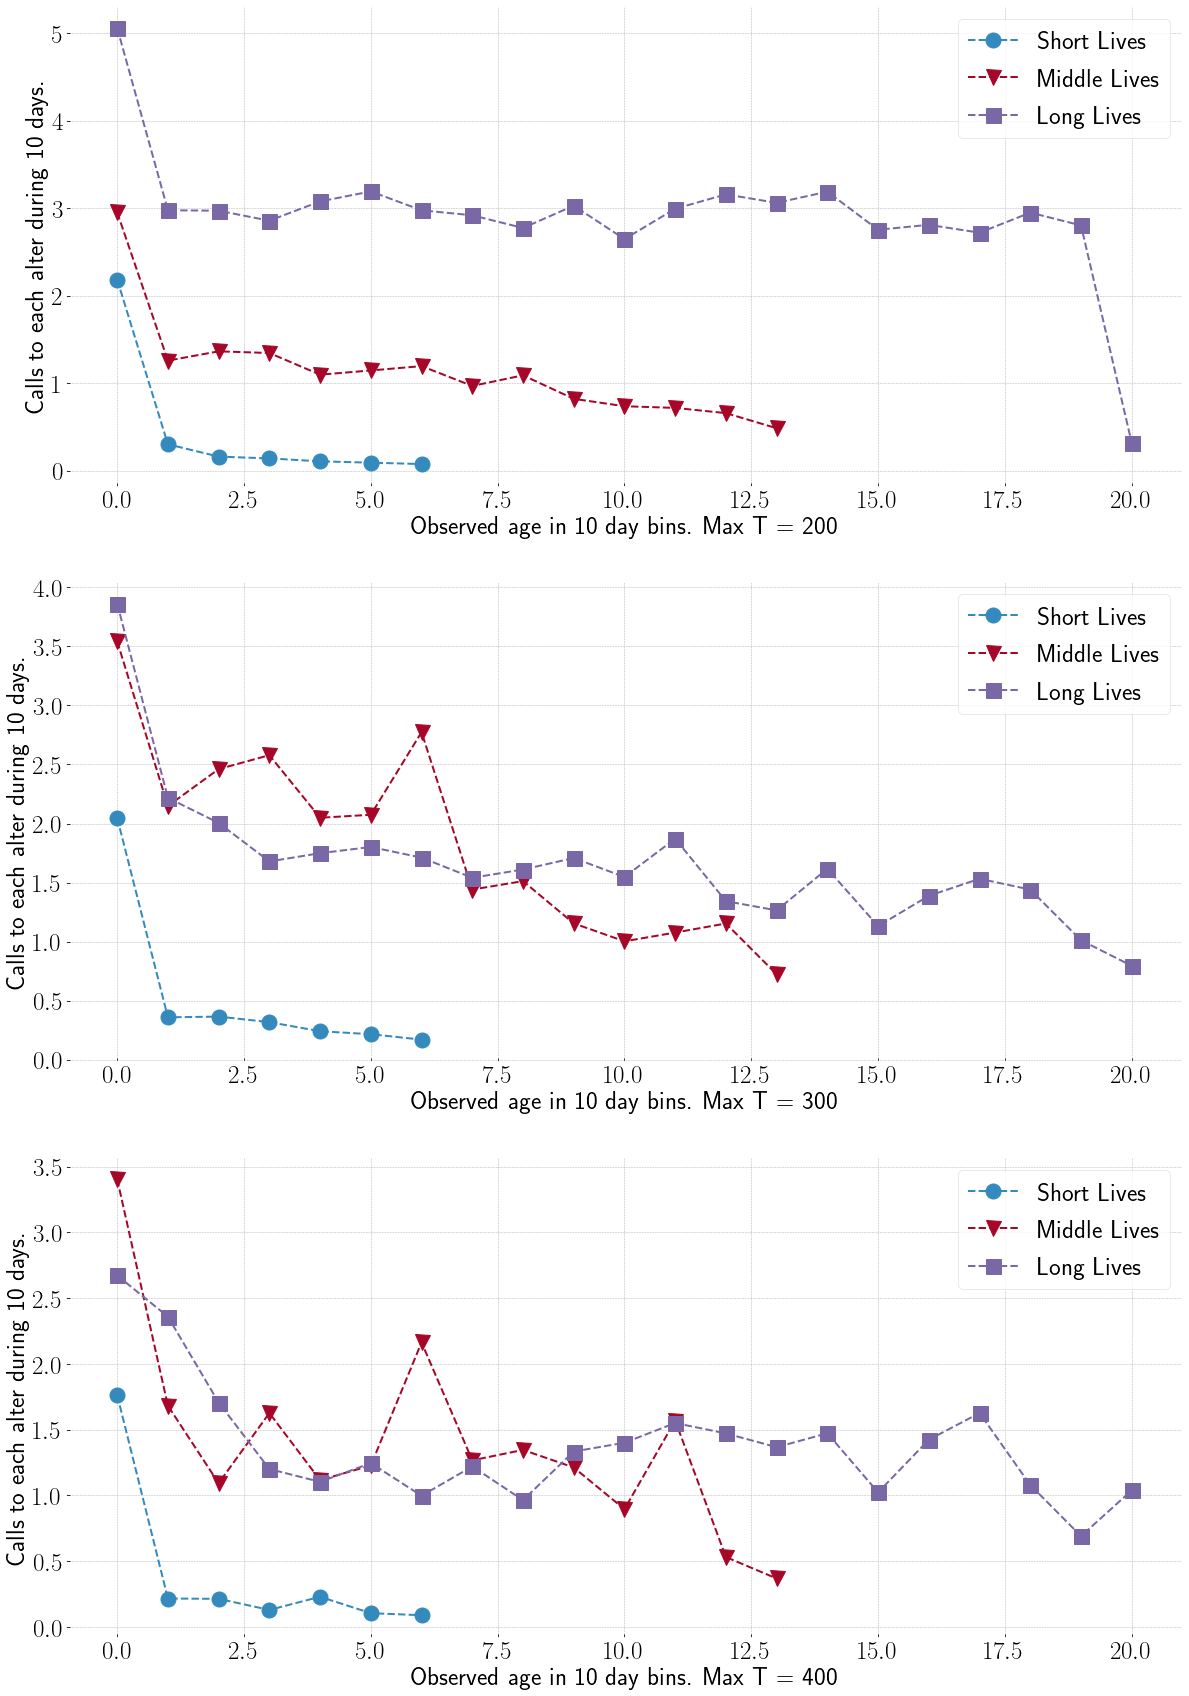

In [222]:
plt.figure(figsize=(20, 30))
labels = ['Short Lives', 'Middle Lives', 'Long Lives']
p = 1
for T in sup1.keys():
    plt.subplot(3,1,p)
    plt.xlabel(f"Observed age in 10 day bins. Max T = {T}")
    plt.ylabel(fr"Calls to each alter during 10 days.")
    for l in range(3):
        plt.plot(sup1[T][int(l)].index, sup1[T][l]['alpha'], marker=markers[int(l)], markersize=15, ls="--", label=labels[int(l)])
    plt.legend()
    p += 1

# Global Time

In [62]:
globaltf = dt.datetime.now() - globalt0
print(f'This notebook took {globaltf}')
os.system(f"notify-send 'Notebook done' 'it took {globaltf}'")

This notebook took 4:04:03.322719


0